# Basic Imports 

In [1]:
import sys
import os
sys.path.append(os.path.expanduser('~/Desktop/diss_scripts/particles-cdssm'))
from particles_cdssm.collectors import ObservationPredictiveParticles, ObservationPredictiveMoments, NLPD
from particles.state_space_models import StochVol, Bootstrap


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import warnings
import seaborn as sns
from tqdm import tqdm
from statsmodels.tsa.stattools import acf
import jax.numpy as jnp
import jax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

warnings.filterwarnings('ignore')

# Import particles package components
import particles
from particles import state_space_models as ssm
from particles import mcmc
from particles import distributions
from particles.collectors import Moments



/Users/ac/Desktop/diss_scripts/GITHooo/UCL-Research-Project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Visualization

Let's visualize the fetched SP500 and NASDAQ data to understand the time series patterns, volatility clustering, and correlation structure.

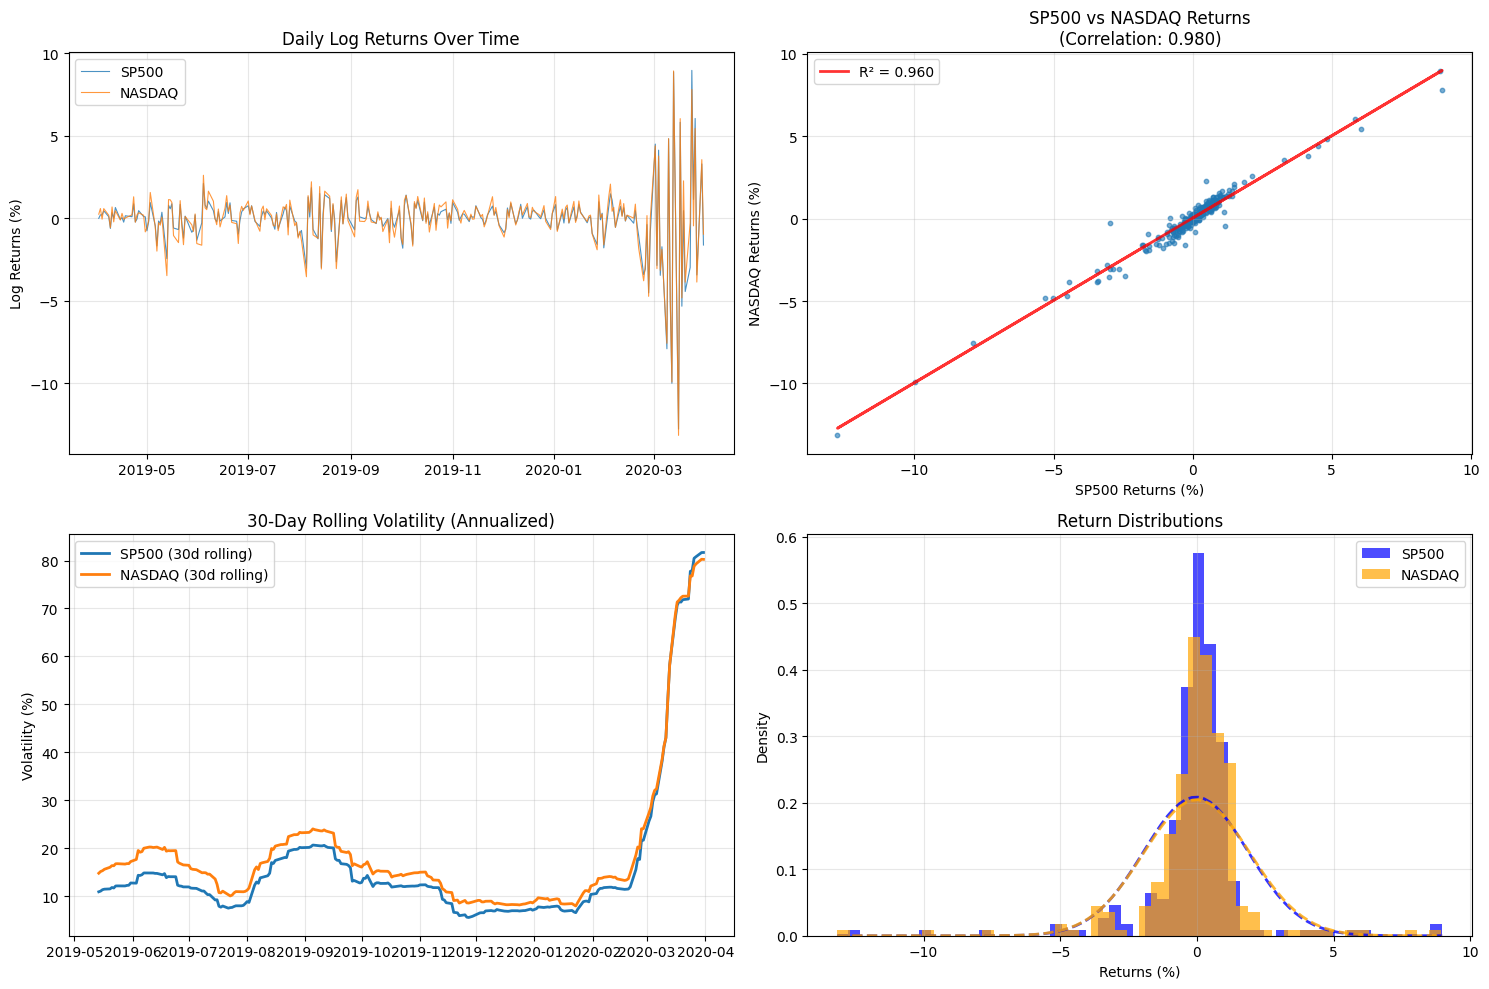


📊 SP500 & NASDAQ DATA OVERVIEW
Data period: 2019-04-02 to 2020-03-31
Total observations: 252

DESCRIPTIVE STATISTICS:
----------------------------------------
  SP500: Mean=-0.041%, Std= 1.91%, Skew=-1.170, Kurt=15.245
 NASDAQ: Mean=-0.007%, Std= 1.95%, Skew=-1.331, Kurt=13.794

CORRELATION & VOLATILITY:
----------------------------------------
Correlation coefficient: 0.9796
Annualized volatility - SP500: 30.36%, NASDAQ: 30.96%

EXTREME EVENTS:
----------------------------------------
  SP500: 1% worst days < -6.59% (3 days), 1% best days > 5.94% (3 days)
 NASDAQ: 1% worst days < -6.16% (3 days), 1% best days > 5.74% (3 days)


In [18]:
def plot_sp500_nasdaq_overview(returns_df):
    """
    Create comprehensive plots showing SP500 and NASDAQ data patterns
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Time series of returns (top-left)
    ax1 = axes[0, 0]
    ax1.plot(returns_df.index, returns_df['SP500'], label='SP500', alpha=0.8, linewidth=0.8)
    ax1.plot(returns_df.index, returns_df['NASDAQ'], label='NASDAQ', alpha=0.8, linewidth=0.8)
    ax1.set_title('Daily Log Returns Over Time')
    ax1.set_ylabel('Log Returns (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter plot of returns (top-right)
    ax2 = axes[0, 1]
    ax2.scatter(returns_df['SP500'], returns_df['NASDAQ'], alpha=0.6, s=10)
    ax2.set_xlabel('SP500 Returns (%)')
    ax2.set_ylabel('NASDAQ Returns (%)')
    ax2.set_title(f'SP500 vs NASDAQ Returns\n(Correlation: {returns_df["SP500"].corr(returns_df["NASDAQ"]):.3f})')
    ax2.grid(True, alpha=0.3)
    
    # Add regression line
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(returns_df['SP500'], returns_df['NASDAQ'])
    line = slope * returns_df['SP500'] + intercept
    ax2.plot(returns_df['SP500'], line, 'r-', alpha=0.8, linewidth=2, label=f'R² = {r_value**2:.3f}')
    ax2.legend()
    
    # 3. Rolling volatility (bottom-left)
    ax3 = axes[1, 0]
    window = 30  # 30-day rolling window
    rolling_vol_sp500 = returns_df['SP500'].rolling(window=window).std() * np.sqrt(252)  # Annualized
    rolling_vol_nasdaq = returns_df['NASDAQ'].rolling(window=window).std() * np.sqrt(252)  # Annualized
    
    ax3.plot(returns_df.index, rolling_vol_sp500, label=f'SP500 ({window}d rolling)', linewidth=2)
    ax3.plot(returns_df.index, rolling_vol_nasdaq, label=f'NASDAQ ({window}d rolling)', linewidth=2)
    ax3.set_title(f'{window}-Day Rolling Volatility (Annualized)')
    ax3.set_ylabel('Volatility (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Distribution comparison (bottom-right)
    ax4 = axes[1, 1]
    ax4.hist(returns_df['SP500'], bins=50, alpha=0.7, label='SP500', density=True, color='blue')
    ax4.hist(returns_df['NASDAQ'], bins=50, alpha=0.7, label='NASDAQ', density=True, color='orange')
    ax4.set_xlabel('Returns (%)')
    ax4.set_ylabel('Density')
    ax4.set_title('Return Distributions')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add normal distribution overlays
    x_range = np.linspace(min(returns_df['SP500'].min(), returns_df['NASDAQ'].min()),
                         max(returns_df['SP500'].max(), returns_df['NASDAQ'].max()), 100)
    
    # SP500 normal overlay
    sp500_normal = stats.norm.pdf(x_range, returns_df['SP500'].mean(), returns_df['SP500'].std())
    ax4.plot(x_range, sp500_normal, 'b--', alpha=0.8, linewidth=2, label='SP500 Normal')
    
    # NASDAQ normal overlay
    nasdaq_normal = stats.norm.pdf(x_range, returns_df['NASDAQ'].mean(), returns_df['NASDAQ'].std())
    ax4.plot(x_range, nasdaq_normal, 'orange', linestyle='--', alpha=0.8, linewidth=2, label='NASDAQ Normal')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    print("\n" + "="*60)
    print("📊 SP500 & NASDAQ DATA OVERVIEW")
    print("="*60)
    print(f"Data period: {returns_df.index[0].date()} to {returns_df.index[-1].date()}")
    print(f"Total observations: {len(returns_df)}")
    print()
    
    print("DESCRIPTIVE STATISTICS:")
    print("-" * 40)
    for col in ['SP500', 'NASDAQ']:
        data = returns_df[col]
        print(f"{col:>7}: Mean={data.mean():6.3f}%, Std={data.std():5.2f}%, Skew={data.skew():6.3f}, Kurt={data.kurtosis():6.3f}")
    
    print()
    print("CORRELATION & VOLATILITY:")
    print("-" * 40)
    print(f"Correlation coefficient: {returns_df['SP500'].corr(returns_df['NASDAQ']):.4f}")
    
    # Annualized volatilities
    sp500_ann_vol = returns_df['SP500'].std() * np.sqrt(252)
    nasdaq_ann_vol = returns_df['NASDAQ'].std() * np.sqrt(252)
    print(f"Annualized volatility - SP500: {sp500_ann_vol:.2f}%, NASDAQ: {nasdaq_ann_vol:.2f}%")
    
    # Extreme events
    print()
    print("EXTREME EVENTS:")
    print("-" * 40)
    for col in ['SP500', 'NASDAQ']:
        data = returns_df[col]
        q01 = data.quantile(0.01)
        q99 = data.quantile(0.99)
        extreme_down = (data <= q01).sum()
        extreme_up = (data >= q99).sum()
        print(f"{col:>7}: 1% worst days < {q01:.2f}% ({extreme_down} days), 1% best days > {q99:.2f}% ({extreme_up} days)")

# Create the visualization
plot_sp500_nasdaq_overview(returns_df)

# Data Fetch (S&P500 & NASDAQ)

In [3]:
def fetch_sp500_nasdaq_data(start_date="2022-04-01", end_date="2023-04-01"):
    
    # Download S&P 500 and NASDAQ data
    tickers = ["^GSPC", "^IXIC"]  # S&P 500 and NASDAQ
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    
    # Extract closing prices
    sp500_close = data['Close']['^GSPC']
    nasdaq_close = data['Close']['^IXIC']
    
    # Calculate log returns (multiply by 100 for percentage)
    sp500_returns = np.log(sp500_close / sp500_close.shift(1)) * 100
    nasdaq_returns = np.log(nasdaq_close / nasdaq_close.shift(1)) * 100
    
    # Combine into a DataFrame
    returns_df = pd.DataFrame({
        'SP500': sp500_returns,
        'NASDAQ': nasdaq_returns
    })
    
    # Drop the first row (NaN from shift)
    returns_df = returns_df.dropna()
    
    # Convert to numpy array for the model (N x 2)
    returns_array = returns_df.values
    
    # Print summary statistics
    print(f"Downloaded {len(returns_df)} trading days")
    print("\nSummary Statistics:")
    print(f"S&P 500  - Mean: {returns_df['SP500'].mean():.3f}%, Std: {returns_df['SP500'].std():.2f}%")
    print(f"NASDAQ   - Mean: {returns_df['NASDAQ'].mean():.3f}%, Std: {returns_df['NASDAQ'].std():.2f}%")
    print(f"Correlation: {returns_df['SP500'].corr(returns_df['NASDAQ']):.3f}")
    
    # Check for any remaining NaNs
    if returns_df.isnull().any().any():
        print(f"\nWarning: Found {returns_df.isnull().sum().sum()} NaN values, removing them...")
        returns_df = returns_df.dropna()
        returns_array = returns_df.values
    
    return returns_df, returns_array

# Fetch the data
returns_df, returns_array = fetch_sp500_nasdaq_data()

# The returns_array is ready to use with the DC_MSV model
# Shape should be (T, 2) where T is number of time periods
print(f"\nReturns array shape: {returns_array.shape}")

Downloaded 250 trading days

Summary Statistics:
S&P 500  - Mean: -0.040%, Std: 1.47%
NASDAQ   - Mean: -0.062%, Std: 1.90%
Correlation: 0.969

Returns array shape: (250, 2)


## Split data into train and test

In [4]:
def split_data_2d(returns_df, returns_array, train_ratio=0.8):
    """Split 2D data into training and testing sets"""
    n_total = len(returns_df)
    n_train = int(n_total * train_ratio)
    
    # Split DataFrame
    train_df = returns_df.iloc[:n_train].copy()
    test_df = returns_df.iloc[n_train:].copy()
    
    # Split numpy array
    train_array = returns_array[:n_train]
    test_array = returns_array[n_train:]
    
    print(f"Data split:")
    print(f"  Training: {len(train_df)} days ({train_df.index[0].date()} to {train_df.index[-1].date()})")
    print(f"  Testing:  {len(test_df)} days ({test_df.index[0].date()} to {test_df.index[-1].date()})")
    
    # Print correlation for each split
    print(f"\nTraining set correlation: {train_df['SP500'].corr(train_df['NASDAQ']):.3f}")
    print(f"Testing set correlation:  {test_df['SP500'].corr(test_df['NASDAQ']):.3f}")
    
    return train_df, test_df, train_array, test_array

# Split the data
train_df, test_df, train_array, test_array = split_data_2d(returns_df, returns_array, train_ratio=0.8)

# The arrays are ready for the DC_MSV model
print(f"\nTraining array shape: {train_array.shape}")
print(f"Testing array shape:  {test_array.shape}")

# You can access individual series if needed:
sp500_train = train_df['SP500'].values
nasdaq_train = train_df['NASDAQ'].values
sp500_test = test_df['SP500'].values
nasdaq_test = test_df['NASDAQ'].values

Data split:
  Training: 200 days (2022-04-04 to 2023-01-19)
  Testing:  50 days (2023-01-20 to 2023-03-31)

Training set correlation: 0.971
Testing set correlation:  0.952

Training array shape: (200, 2)
Testing array shape:  (50, 2)


# Defining the model using particles

In [5]:
class DC_MSV(ssm.StateSpaceModel):
    def __init__(self, mu1, mu2, phi11, phi22, sigma_eta1, sigma_eta2, psi0, psi, sigma_rho):
        self.mu1 = mu1
        self.mu2 = mu2
        self.phi11 = phi11
        self.phi22 = phi22
        self.sigma_eta1 = sigma_eta1
        self.sigma_eta2 = sigma_eta2
        self.psi0 = psi0
        self.psi = psi
        self.sigma_rho = sigma_rho
        self.a = np.array([mu1 * (1 - phi11), mu2 * (1 - phi22), psi0 * (1 - psi)])
        self.B = np.diag([phi11, phi22, psi])
        self.Sigma = np.diag([sigma_eta1**2, sigma_eta2**2, sigma_rho**2])

    def px0(self):
        return ssm.MultivariateNormal(mean=[self.mu1, self.mu2, self.psi0], cov=np.eye(3))

    def px(self, t, xp):
        mean = self.a + np.dot(self.B, xp.T).T
        return ssm.MultivariateNormal(mean=mean, cov=self.Sigma)

    def py(self, t, x):
        h1, h2, q = x[:, 0], x[:, 1], x[:, 2]
        rho = (np.exp(q) - 1) / (np.exp(q) + 1)
        Omega = np.array([np.exp(h1 / 2), np.exp(h2 / 2)]).T
        Sigma_eps = np.array([[1, rho], [rho, 1]])
        cov = Omega[:, None] * Sigma_eps * Omega[:, :, None]
        return ssm.MultivariateNormal(mean=np.zeros(2), cov=cov)

## B-Scholes alternative (bivariate normal)

In [6]:


class BivariateNormal:
    """Bivariate Normal model with constant mean and covariance
    
    This serves as a baseline model for comparison with DC_MSV.
    Parameters are estimated from sample moments.
    """
    
    def __init__(self, data):
        """
        Initialize with sample mean and covariance from data
        
        Parameters:
        -----------
        data : array-like, shape (T, 2)
            Bivariate time series data
        """
        self.data = np.array(data)
        self.T, self.dim = self.data.shape
        
        # Estimate parameters from sample
        self.mean = np.mean(self.data, axis=0)
        self.cov = np.cov(self.data.T)
        
        # Extract standard deviations and correlation
        self.std1 = np.sqrt(self.cov[0, 0])
        self.std2 = np.sqrt(self.cov[1, 1])
        self.corr = self.cov[0, 1] / (self.std1 * self.std2)
        
        # Create the distribution
        self.dist = stats.multivariate_normal(mean=self.mean, cov=self.cov)
        
        print("Bivariate Normal Model Parameters:")
        print(f"  Mean (SP500):  {self.mean[0]:.4f}%")
        print(f"  Mean (NASDAQ): {self.mean[1]:.4f}%")
        print(f"  Std (SP500):   {self.std1:.4f}%")
        print(f"  Std (NASDAQ):  {self.std2:.4f}%")
        print(f"  Correlation:   {self.corr:.4f}")
    
    def log_likelihood(self, data=None):
        """Calculate log-likelihood of the data"""
        if data is None:
            data = self.data
        return np.sum(self.dist.logpdf(data))
    
    def sample(self, n_samples):
        """Generate samples from the model"""
        return self.dist.rvs(size=n_samples)
    
    def predict(self, n_ahead=1):
        """
        Predict future values (just returns the mean for this IID model)
        
        Returns:
        --------
        mean : array, shape (n_ahead, 2)
        cov : array, shape (2, 2)
        """
        mean_pred = np.tile(self.mean, (n_ahead, 1))
        return mean_pred, self.cov

# Create baseline model from training data
baseline_model = BivariateNormal(train_array)

# Calculate log-likelihood on training data
train_ll = baseline_model.log_likelihood()
print(f"\nTraining log-likelihood: {train_ll:.2f}")

# Calculate log-likelihood on test data
test_ll = baseline_model.log_likelihood(test_array)
print(f"Test log-likelihood: {test_ll:.2f}")


Bivariate Normal Model Parameters:
  Mean (SP500):  -0.0768%
  Mean (NASDAQ): -0.1366%
  Std (SP500):   1.5557%
  Std (NASDAQ):  1.9998%
  Correlation:   0.9710

Training log-likelihood: -507.39
Test log-likelihood: -111.83


# Bayesian Estimation

In [7]:
import numpy as np
import jax.numpy as jnp
import jax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def numpyro_estimation_dc_msv(returns_array, n_iter=10000, n_warmup=2000, n_chains=2):
    """
    Optimized HMC estimation for DC-MSV model using non-centered parameterization.
    """
    jax.config.update("jax_platform_name", "cpu")
    
    T, _ = returns_array.shape
    y_data = jnp.array(returns_array)
    
    def dc_msv_model(y=None):
        # Priors
        mu1 = numpyro.sample('mu1', dist.Normal(0., 5.))
        mu2 = numpyro.sample('mu2', dist.Normal(0., 5.))
        phi11 = numpyro.sample('phi11', dist.Beta(20., 1.5))
        phi22 = numpyro.sample('phi22', dist.Beta(20., 1.5))
        sigma1 = numpyro.sample('sigma1', dist.InverseGamma(2.5, 0.025))
        sigma2 = numpyro.sample('sigma2', dist.InverseGamma(2.5, 0.025))
        mu0 = numpyro.sample('mu0', dist.Normal(0.7, 3.))
        phi = numpyro.sample('phi', dist.Beta(20., 1.5))
        sigma_rho = numpyro.sample('sigma_rho', dist.InverseGamma(2.5, 0.025))

        # Initial state (non-centered)
        h1_0_tilde = numpyro.sample('h1_0_tilde', dist.Normal(0., 1.))
        h2_0_tilde = numpyro.sample('h2_0_tilde', dist.Normal(0., 1.))
        q_0_tilde = numpyro.sample('q_0_tilde', dist.Normal(0., 1.))
        x_0 = jnp.array([mu1 + 0.1 * h1_0_tilde, mu2 + 0.1 * h2_0_tilde, mu0 + 0.1 * q_0_tilde])

        # Vectorized state dynamics (non-centered)
        with numpyro.plate('time', T):
            h1_tilde = numpyro.sample('h1_tilde', dist.Normal(0., 1.), sample_shape=(T,))
            h2_tilde = numpyro.sample('h2_tilde', dist.Normal(0., 1.), sample_shape=(T,))
            q_tilde = numpyro.sample('q_tilde', dist.Normal(0., 1.), sample_shape=(T,))

            # Compute states
            states = jnp.zeros((T, 3))
            states = states.at[0].set(x_0)
            for t in range(1, T):
                h1_prev, h2_prev, q_prev = states[t-1]
                states = states.at[t, 0].set(mu1 + phi11 * (h1_prev - mu1) + sigma1 * h1_tilde[t])
                states = states.at[t, 1].set(mu2 + phi22 * (h2_prev - mu2) + sigma2 * h2_tilde[t])
                states = states.at[t, 2].set(mu0 + phi * (q_prev - mu0) + sigma_rho * q_tilde[t])

        # Store states explicitly
        numpyro.deterministic('states', states)

        # Observation model
        with numpyro.plate('obs', T):
            h1, h2, q = states[:, 0], states[:, 1], states[:, 2]
            rho_t = (jnp.exp(q) - 1) / (jnp.exp(q) + 1)
            Omega_t = jnp.stack([jnp.exp(h1 / 2), jnp.exp(h2 / 2)], axis=1)
            covs = jnp.zeros((T, 2, 2))
            covs = covs.at[:, 0, 0].set(Omega_t[:, 0]**2)
            covs = covs.at[:, 1, 1].set(Omega_t[:, 1]**2)
            covs = covs.at[:, 0, 1].set(rho_t * Omega_t[:, 0] * Omega_t[:, 1])
            covs = covs.at[:, 1, 0].set(rho_t * Omega_t[:, 0] * Omega_t[:, 1])
            covs = covs + 1e-5 * jnp.eye(2)
            numpyro.sample('y', dist.MultivariateNormal(loc=jnp.zeros(2), covariance_matrix=covs), obs=y)

    print(f"Running optimized DC-MSV estimation with NumPyro...")
    
    # Run NUTS
    nuts_kernel = NUTS(dc_msv_model)
    mcmc = MCMC(
        nuts_kernel,
        num_warmup=n_warmup,
        num_samples=n_iter - n_warmup,
        num_chains=n_chains,
        progress_bar=True
    )
    
    mcmc.run(jax.random.PRNGKey(0), y=y_data)
    
    # Extract samples
    samples = mcmc.get_samples()
    
    # Parameter estimates
    params = ['mu1', 'mu2', 'phi11', 'phi22', 'sigma1', 'sigma2', 'mu0', 'phi', 'sigma_rho']
    param_estimates = {}
    
    for param in params:
        param_samples = samples[param]
        param_estimates[param] = {
            'mean': float(jnp.mean(param_samples)),
            'std': float(jnp.std(param_samples)),
            'quantiles': [float(q) for q in jnp.quantile(param_samples, jnp.array([0.025, 0.5, 0.975]))]
        }
    
    print("\n✓ NumPyro estimation completed")
    print("\nParameter estimates:")
    for param, est in param_estimates.items():
        print(f"  {param}: {est['mean']:.4f} ± {est['std']:.4f}")
    
    return {
        'mcmc': mcmc,
        'samples': samples,
        'estimates': param_estimates,
        'param_names': params
    }

In [8]:
# 1. Fetch 2D data
returns_df, returns_array = fetch_sp500_nasdaq_data()

# 2. Split the data
train_df, test_df, train_array, test_array = split_data_2d(returns_df, returns_array, train_ratio=0.8)

# 3. Convert percentage returns to decimal returns
train_array_decimal = train_array / 100
test_array_decimal = test_array / 100

# 4. Create baseline model
baseline_model = BivariateNormal(train_array_decimal)


# Run with fewer iterations for testing
# Run the efficient version
print("Running efficient estimation...")
results = numpyro_estimation_dc_msv(train_array_decimal, n_iter=10000, n_warmup=2000)

Downloaded 250 trading days

Summary Statistics:
S&P 500  - Mean: -0.040%, Std: 1.47%
NASDAQ   - Mean: -0.062%, Std: 1.90%
Correlation: 0.969
Data split:
  Training: 200 days (2022-04-04 to 2023-01-19)
  Testing:  50 days (2023-01-20 to 2023-03-31)

Training set correlation: 0.971
Testing set correlation:  0.952
Bivariate Normal Model Parameters:
  Mean (SP500):  -0.0008%
  Mean (NASDAQ): -0.0014%
  Std (SP500):   0.0156%
  Std (NASDAQ):  0.0200%
  Correlation:   0.9710
Running efficient estimation...
Running optimized DC-MSV estimation with NumPyro...


sample: 100%|██████████| 10000/10000 [01:13<00:00, 136.85it/s, 15 steps of size 2.13e-01. acc. prob=0.89]



✓ NumPyro estimation completed

Parameter estimates:
  mu1: -8.3605 ± 0.1110
  mu2: -7.8474 ± 0.1114
  phi11: 0.9283 ± 0.0520
  phi22: 0.9376 ± 0.0500
  sigma1: 0.0138 ± 0.0097
  sigma2: 0.0136 ± 0.0090
  mu0: 7.8082 ± 1.2199
  phi: 0.9303 ± 0.0538
  sigma_rho: 0.0163 ± 0.0179



📊 DC_MSV MCMC Convergence Diagnostics:
Total iterations: 16000
Burn-in samples: 0
Post-burn samples: 16000

Effective Sample Sizes:

Volatility parameters:
  mu1: 4374.8 (27.3% of total)
  mu2: 4240.4 (26.5% of total)
  phi11: 9316.7 (58.2% of total)
  phi22: 7934.3 (49.6% of total)
  sigma1: 4442.7 (27.8% of total)
  sigma2: 5152.9 (32.2% of total)

Correlation parameters:
  mu0: 5829.9 (36.4% of total)
  phi: 10426.3 (65.2% of total)
  sigma_rho: 4626.1 (28.9% of total)


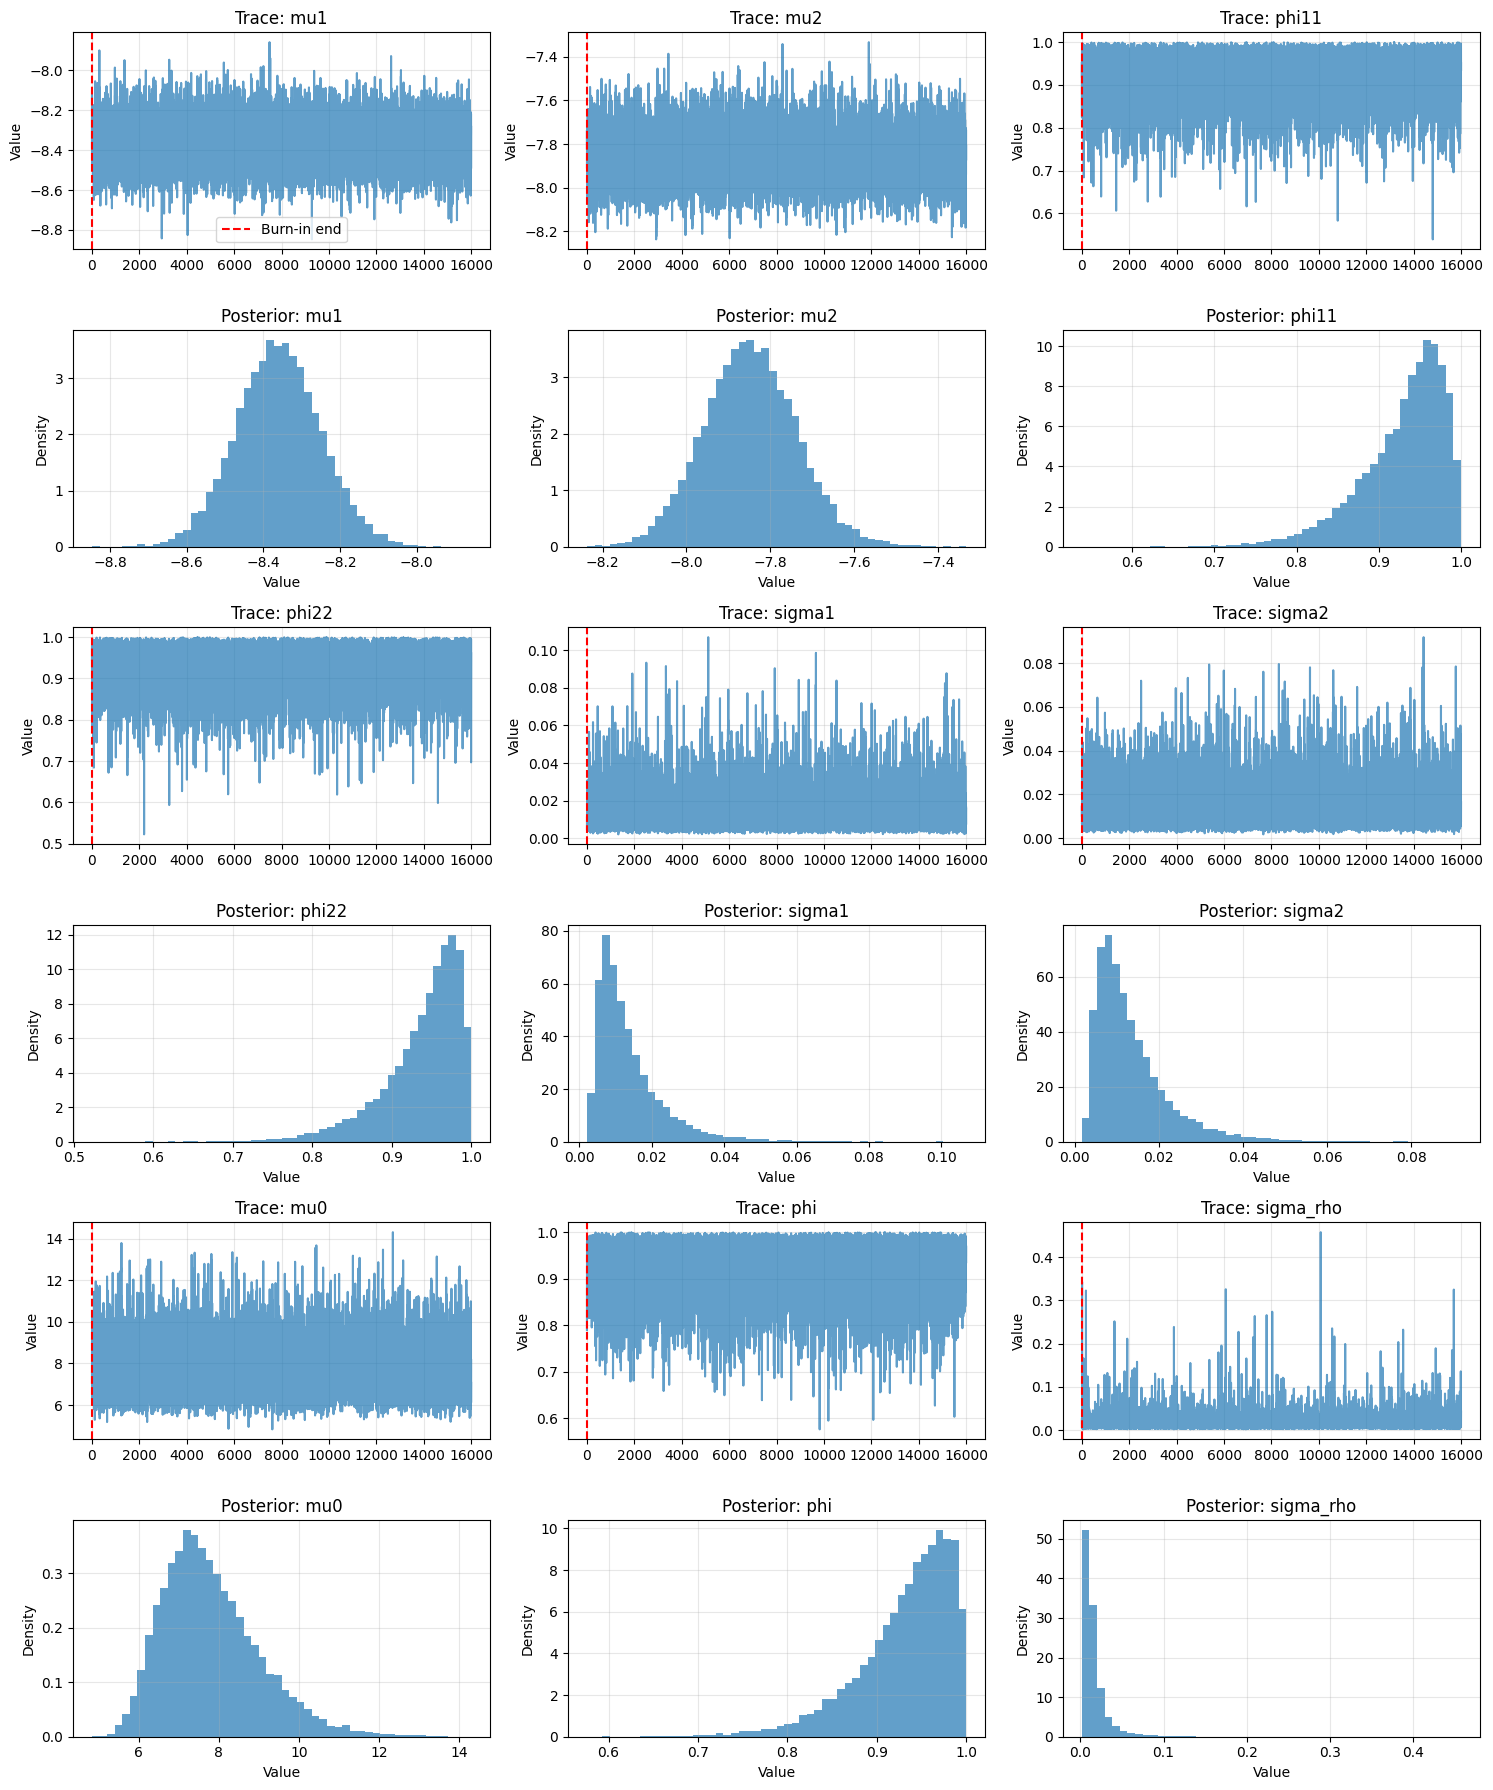

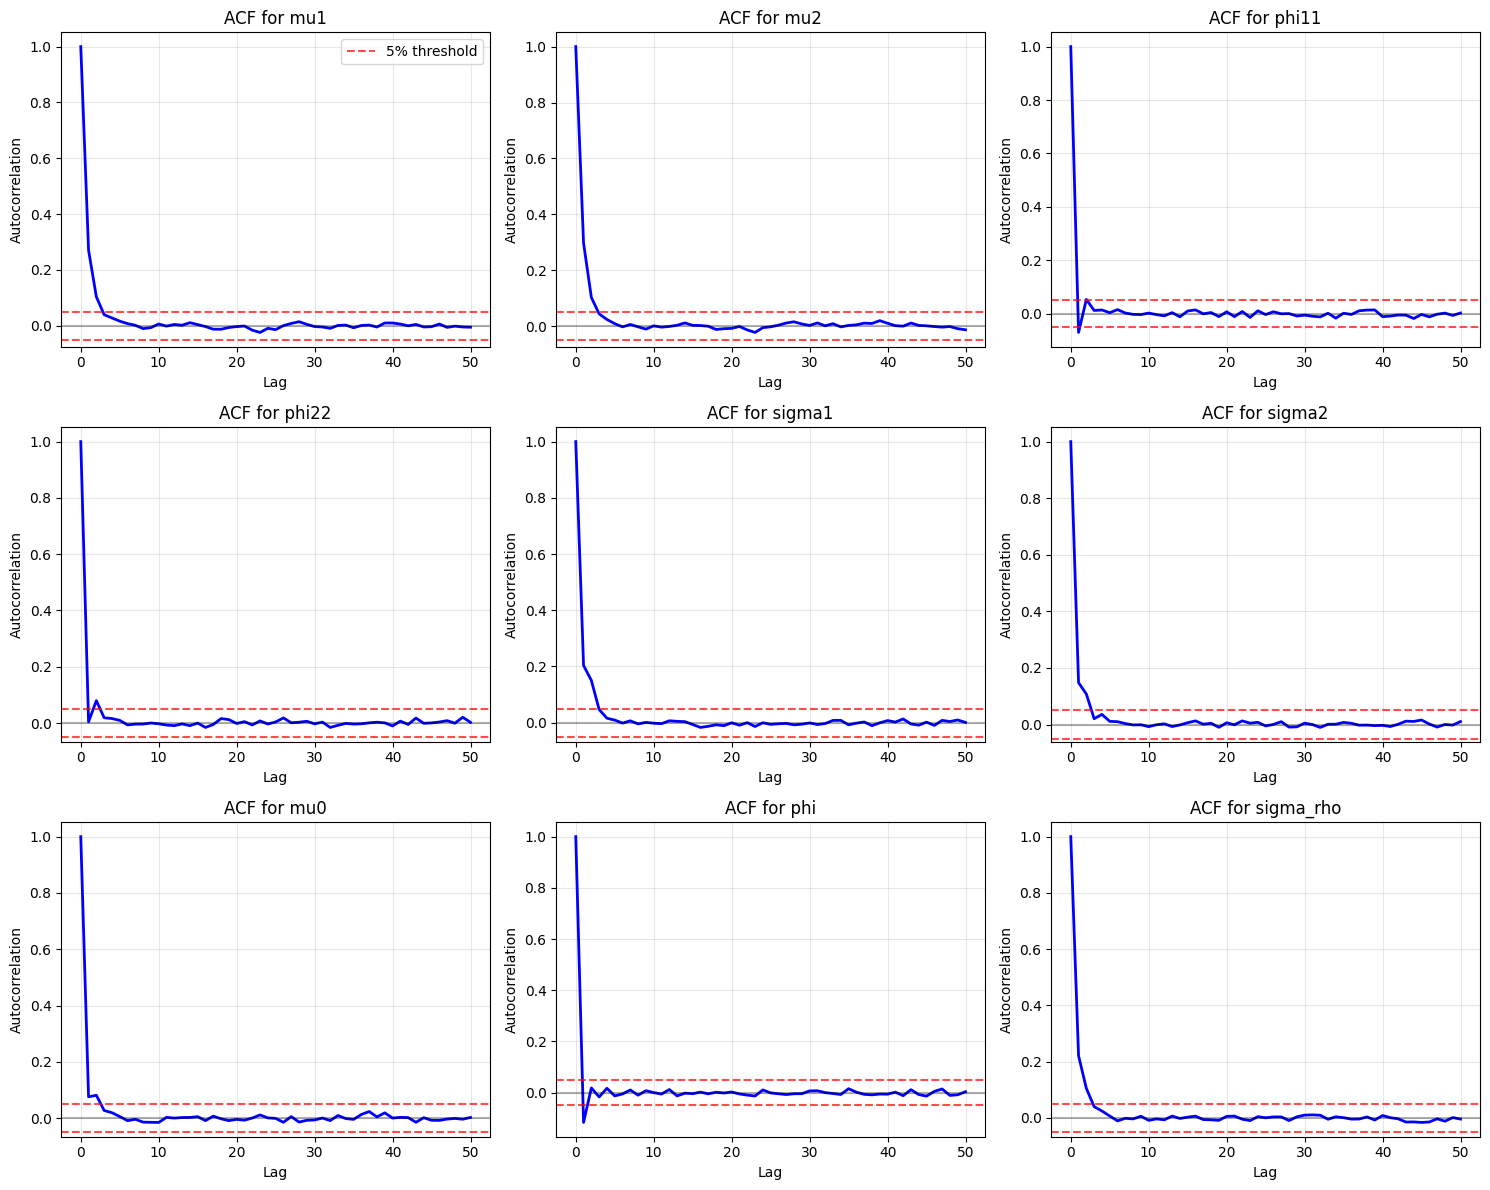


📈 Parameter Summary Statistics:
--------------------------------------------------
Parameter    Mean       Std        95% CI              
--------------------------------------------------
mu1          -8.3605    0.1110     [-8.5772, -8.1393]
mu2          -7.8474    0.1114     [-8.0612, -7.6222]
phi11        0.9283     0.0520     [0.7985, 0.9932]
phi22        0.9376     0.0500     [0.8082, 0.9951]
sigma1       0.0138     0.0097     [0.0038, 0.0399]
sigma2       0.0136     0.0090     [0.0038, 0.0381]
mu0          7.8082     1.2199     [5.9383, 10.6262]
phi          0.9303     0.0538     [0.7941, 0.9947]
sigma_rho    0.0163     0.0179     [0.0039, 0.0593]

📊 NumPyro-Specific Diagnostics:
R-hat values not available

Posterior Summary:
------------------------------------------------------------
Parameter    Mean       Std        2.5%       97.5%     
------------------------------------------------------------
mu1          -8.3605    0.1110     -8.5772    -8.1393   
mu2          -7.8474

In [9]:
def plot_acf(chain, param_names, max_lags=50):
    """Plot autocorrelation function for MCMC chains"""
    from statsmodels.tsa.stattools import acf
    
    n_params = len(param_names)
    n_cols = 3  # Display 3 columns for better layout with 9 parameters
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if n_params > 1 else [axes]
    
    for i, param in enumerate(param_names):
        # Calculate ACF
        autocorr = acf(chain[:, i], nlags=max_lags, fft=True)
        lags = np.arange(len(autocorr))
        
        axes[i].plot(lags, autocorr, 'b-', linewidth=2)
        axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='5% threshold')
        axes[i].axhline(y=-0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Autocorrelation')
        axes[i].set_title(f'ACF for {param}')
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend()
    
    # Hide empty subplots
    for i in range(n_params, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def effective_sample_size(chain):
    """Calculate effective sample size for MCMC chains"""
    from statsmodels.tsa.stattools import acf
    
    n_samples, n_params = chain.shape
    ess_values = []
    
    for i in range(n_params):
        # Calculate autocorrelation
        max_lags = min(n_samples // 4, 200)
        try:
            autocorrs = acf(chain[:, i], nlags=max_lags, fft=True)
            
            # Find first negative autocorrelation or where it drops below 0.05
            cutoff = 1
            for lag in range(1, len(autocorrs)):
                if autocorrs[lag] <= 0.05:
                    cutoff = lag
                    break
            
            # Calculate integrated autocorrelation time
            tau_int = 1 + 2 * np.sum(autocorrs[1:cutoff+1])
            
            # Effective sample size
            ess = n_samples / (2 * tau_int)
            ess_values.append(max(ess, 1))
            
        except:
            # Fallback calculation
            ess_values.append(n_samples / 10)
    
    return np.array(ess_values)

def mcmc_diagnostics_2d(chain, param_names, burned_chain):
    """Comprehensive MCMC diagnostics for DC_MSV model"""
    print("\n📊 DC_MSV MCMC Convergence Diagnostics:")
    print("=" * 50)
    
    # Basic chain statistics
    n_total, n_params = chain.shape
    n_burned = len(burned_chain)
    
    print(f"Total iterations: {n_total}")
    print(f"Burn-in samples: {n_total - n_burned}")
    print(f"Post-burn samples: {n_burned}")
    
    # Effective sample size
    ess = effective_sample_size(burned_chain)
    print(f"\nEffective Sample Sizes:")
    
    # Group parameters by type for better display
    vol_params = ['mu1', 'mu2', 'phi11', 'phi22', 'sigma1', 'sigma2']
    corr_params = ['mu0', 'phi', 'sigma_rho']
    
    print("\nVolatility parameters:")
    for param in vol_params:
        if param in param_names:
            i = param_names.index(param)
            print(f"  {param}: {ess[i]:.1f} ({ess[i]/n_burned:.1%} of total)")
    
    print("\nCorrelation parameters:")
    for param in corr_params:
        if param in param_names:
            i = param_names.index(param)
            print(f"  {param}: {ess[i]:.1f} ({ess[i]/n_burned:.1%} of total)")
    
    # Plot traces and densities in a grid layout
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(15, n_rows * 6))
    
    for i, param in enumerate(param_names):
        row_trace = 2 * (i // n_cols)
        row_dens = row_trace + 1
        col = i % n_cols
        
        # Trace plot
        axes[row_trace, col].plot(chain[:, i], alpha=0.7)
        axes[row_trace, col].axvline(x=n_total-n_burned, color='r', linestyle='--', 
                                     label='Burn-in end')
        axes[row_trace, col].set_title(f'Trace: {param}')
        axes[row_trace, col].set_ylabel('Value')
        axes[row_trace, col].grid(True, alpha=0.3)
        if i == 0:
            axes[row_trace, col].legend()
        
        # Density plot
        axes[row_dens, col].hist(burned_chain[:, i], bins=50, density=True, alpha=0.7)
        axes[row_dens, col].set_title(f'Posterior: {param}')
        axes[row_dens, col].set_xlabel('Value')
        axes[row_dens, col].set_ylabel('Density')
        axes[row_dens, col].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_params, n_rows * n_cols):
        row_trace = 2 * (i // n_cols)
        row_dens = row_trace + 1
        col = i % n_cols
        axes[row_trace, col].set_visible(False)
        axes[row_dens, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # ACF plots
    plot_acf(burned_chain, param_names)
    
    # Summary statistics
    print("\n📈 Parameter Summary Statistics:")
    print("-" * 50)
    print(f"{'Parameter':<12} {'Mean':<10} {'Std':<10} {'95% CI':<20}")
    print("-" * 50)
    
    for i, param in enumerate(param_names):
        mean = np.mean(burned_chain[:, i])
        std = np.std(burned_chain[:, i])
        ci_low, ci_high = np.percentile(burned_chain[:, i], [2.5, 97.5])
        print(f"{param:<12} {mean:<10.4f} {std:<10.4f} [{ci_low:.4f}, {ci_high:.4f}]")
    
    return ess

def convert_numpyro_to_chain(numpyro_results):
    """Convert NumPyro results to chain format for diagnostics"""
    samples = numpyro_results['samples']
    param_names = numpyro_results['param_names']
    
    # Get number of samples
    n_samples = len(samples[param_names[0]])
    n_params = len(param_names)
    
    # Create chain array
    chain = np.zeros((n_samples, n_params))
    for i, param in enumerate(param_names):
        chain[:, i] = np.array(samples[param])
    
    # NumPyro already excludes warmup, so burned_chain = chain
    burned_chain = chain
    
    return chain, burned_chain

# Convert NumPyro results to chain format
chain, burned_chain = convert_numpyro_to_chain(results)

# Run diagnostics
ess = mcmc_diagnostics_2d(chain, 
                         results['param_names'], 
                         burned_chain)

# Additional NumPyro-specific diagnostics
print("\n📊 NumPyro-Specific Diagnostics:")
print("=" * 50)

# Get r_hat values if available
if hasattr(results['mcmc'], 'get_extra_fields'):
    try:
        r_hat = results['mcmc'].get_extra_fields()['r_hat']
        print("\nGelman-Rubin R-hat values:")
        for i, param in enumerate(results['param_names']):
            if param in r_hat:
                print(f"  {param}: {r_hat[param]:.3f}")
    except:
        print("R-hat values not available")

# Print summary statistics
print("\nPosterior Summary:")
print("-" * 60)
print(f"{'Parameter':<12} {'Mean':<10} {'Std':<10} {'2.5%':<10} {'97.5%':<10}")
print("-" * 60)
for param in results['param_names']:
    est = results['estimates'][param]
    print(f"{param:<12} {est['mean']:<10.4f} {est['std']:<10.4f} "
          f"{est['quantiles'][0]:<10.4f} {est['quantiles'][2]:<10.4f}")

# NLPD Case

In [21]:
import numpy as np
import jax.numpy as jnp
import jax
from jax import vmap
from scipy.stats import wilcoxon, multivariate_normal
from scipy.stats import t
import matplotlib.pyplot as plt
from tqdm import tqdm

def multivariate_normal_logpdf(x, mean, cov):
    """
    JAX-native multivariate normal log-pdf for 2D data.
    
    Parameters:
    -----------
    x : jnp.ndarray, shape (2,)
        Data point.
    mean : jnp.ndarray, shape (2,)
        Mean vector.
    cov : jnp.ndarray, shape (2, 2)
        Covariance matrix.
    
    Returns:
    --------
    logpdf : float
        Log probability density.
    """
    k = 2  # 2D data
    x_mu = x - mean
    cov_reg = cov + 1e-5 * jnp.eye(2)  # Regularization for numerical stability
    
    # Use more stable computation
    inv_cov = jnp.linalg.inv(cov_reg)
    log_det = jnp.linalg.slogdet(cov_reg)[1]
    mahalanobis = jnp.dot(x_mu, jnp.dot(inv_cov, x_mu))
    
    return -0.5 * (k * jnp.log(2 * jnp.pi) + log_det + mahalanobis)

def calculate_nlpd_2d(returns_array, model_type, params=None, mcmc_samples=None):
    """
    Calculate NLPD scores for 2D models (BivariateNormal or DC-MSV).

    Parameters:
    -----------
    returns_array : array-like, shape (T, 2)
        Test data (e.g., S&P 500 and NASDAQ returns).
    model_type : str
        Either 'bivariate_normal' or 'dc_msv'.
    params : dict, optional
        For 'dc_msv', dict of parameter estimates from HMC.
    mcmc_samples : dict, optional
        For 'dc_msv', full HMC samples including latent states.

    Returns:
    --------
    nlpd_scores : array, shape (T,)
        Negative log predictive density for each time step.
    """
    T = len(returns_array)
    returns_array = np.array(returns_array)
    nlpd_scores = np.zeros(T)

    if model_type == 'bivariate_normal':
        # Use sample mean and covariance with SciPy (faster for single covariance)
        mean = np.mean(returns_array, axis=0)
        cov = np.cov(returns_array.T)
        cov += 1e-5 * np.eye(2)  # Regularization
        dist = multivariate_normal(mean=mean, cov=cov)
        
        for t in range(T):
            # NLPD = -log(p(y_t))
            log_prob = dist.logpdf(returns_array[t])
            nlpd_scores[t] = -log_prob

    elif model_type == 'dc_msv' and params is not None and mcmc_samples is not None:
        # Subsample HMC samples to reduce computation
        N_samples = len(mcmc_samples['mu1'])
        subsample_size = min(1000, N_samples)  # Use up to 1000 samples
        indices = np.random.choice(N_samples, size=subsample_size, replace=False)
        
        # Extract subsampled parameters
        mu1_samples = mcmc_samples['mu1'][indices]
        mu2_samples = mcmc_samples['mu2'][indices]
        phi11_samples = mcmc_samples['phi11'][indices]
        phi22_samples = mcmc_samples['phi22'][indices]
        sigma1_samples = mcmc_samples['sigma1'][indices]
        sigma2_samples = mcmc_samples['sigma2'][indices]
        mu0_samples = mcmc_samples['mu0'][indices]
        phi_samples = mcmc_samples['phi'][indices]
        sigma_rho_samples = mcmc_samples['sigma_rho'][indices]
        states_samples = mcmc_samples['states'][indices]  # Shape: (subsample_size, T_train, 3)

        @jax.jit
        def predict_one_step_vectorized(h1_prev, h2_prev, q_prev, mu1, mu2, phi11, phi22, sigma1, sigma2, mu0, phi, sigma_rho):
            """Predict next covariance matrices for all samples."""
            key = jax.random.PRNGKey(42)  # Fixed seed for reproducibility
            
            # Predict next latent states
            h1_mean = mu1 + phi11 * (h1_prev - mu1)
            h2_mean = mu2 + phi22 * (h2_prev - mu2)
            q_mean = mu0 + phi * (q_prev - mu0)
            
            # Add noise
            h1_next = h1_mean + sigma1 * jax.random.normal(key, shape=mu1.shape)
            h2_next = h2_mean + sigma2 * jax.random.normal(key + 1, shape=mu2.shape)
            q_next = q_mean + sigma_rho * jax.random.normal(key + 2, shape=mu0.shape)
            
            # Transform to correlation and volatilities
            rho_t = (jnp.exp(q_next) - 1) / (jnp.exp(q_next) + 1)
            vol1 = jnp.exp(h1_next / 2)
            vol2 = jnp.exp(h2_next / 2)
            
            # Construct covariance matrices
            cov11 = vol1**2
            cov22 = vol2**2
            cov12 = rho_t * vol1 * vol2
            
            return cov11, cov12, cov22

        # Vectorize over samples
        predict_vectorized = vmap(predict_one_step_vectorized)

        for t in tqdm(range(T), desc="Calculating DC-MSV NLPD"):
            if t == 0:
                # Use initial states
                h1_prev = mu1_samples
                h2_prev = mu2_samples
                q_prev = mu0_samples
            else:
                # Use last states from training
                h1_prev = states_samples[:, -1, 0]
                h2_prev = states_samples[:, -1, 1]
                q_prev = states_samples[:, -1, 2]
            
            # Predict covariances for all samples
            cov11, cov12, cov22 = predict_vectorized(
                h1_prev, h2_prev, q_prev,
                mu1_samples, mu2_samples, phi11_samples, phi22_samples,
                sigma1_samples, sigma2_samples, mu0_samples, phi_samples, sigma_rho_samples
            )
            
            # Compute log probabilities for each sample
            y_t = returns_array[t]
            log_probs = []
            
            for i in range(subsample_size):
                # Construct covariance matrix for sample i
                cov_i = jnp.array([[cov11[i], cov12[i]], 
                                   [cov12[i], cov22[i]]])
                
                # Compute log probability
                log_prob_i = multivariate_normal_logpdf(
                    jnp.array(y_t), 
                    jnp.zeros(2), 
                    cov_i
                )
                log_probs.append(log_prob_i)
            
            # Average probabilities (not log probabilities) using log-sum-exp trick
            log_probs = jnp.array(log_probs)
            max_log_prob = jnp.max(log_probs)
            log_avg_prob = max_log_prob + jnp.log(jnp.mean(jnp.exp(log_probs - max_log_prob)))
            
            # NLPD is negative log predictive density
            nlpd_scores[t] = -float(log_avg_prob)

    else:
        raise ValueError("For 'dc_msv', both params and mcmc_samples must be provided.")

    return nlpd_scores

def compare_nlpd_scores_2d(dc_msv_nlpd, baseline_nlpd, test_df):
    """
    Compare NLPD scores between DC-MSV and Bivariate Normal.

    Parameters:
    -----------
    dc_msv_nlpd : array, shape (T,)
        NLPD scores for DC-MSV.
    baseline_nlpd : array, shape (T,)
        NLPD scores for Bivariate Normal.
    test_df : pandas.DataFrame
        Test data with index for plotting.

    Returns:
    --------
    dict : Comparison results (means, improvement, p-value).
    """
    # Ensure same length
    min_length = min(len(dc_msv_nlpd), len(baseline_nlpd))
    dc_msv_aligned = dc_msv_nlpd[:min_length]
    baseline_aligned = baseline_nlpd[:min_length]
    
    # Calculate statistics
    dc_msv_mean = np.mean(dc_msv_aligned)
    baseline_mean = np.mean(baseline_aligned)
    improvement = (baseline_mean - dc_msv_mean) / baseline_mean * 100
    
    # Wilcoxon signed-rank test
    stat, p_value = wilcoxon(baseline_aligned, dc_msv_aligned, alternative='two-sided')
    
    # Confidence intervals for means
    def ci_mean(data, confidence=0.95):
        n = len(data)
        mean = np.mean(data)
        std = np.std(data, ddof=1) / np.sqrt(n)
        margin = t.ppf((1 + confidence) / 2, n-1) * std
        return mean, mean - margin, mean + margin
    
    dc_msv_ci = ci_mean(dc_msv_aligned)
    baseline_ci = ci_mean(baseline_aligned)
    
    print(f"\n📊 NLPD COMPARISON RESULTS (2D):")
    print(f"=" * 50)
    print(f"DC-MSV NLPD:              {dc_msv_mean:.4f} (95% CI: {dc_msv_ci[1]:.4f}, {dc_msv_ci[2]:.4f})")
    print(f"Bivariate Normal NLPD:    {baseline_mean:.4f} (95% CI: {baseline_ci[1]:.4f}, {baseline_ci[2]:.4f})")
    print(f"Improvement:              {improvement:.1f}%")
    print(f"Statistical significance:  p = {p_value:.4f} (Wilcoxon)")
    
    if improvement > 0 and p_value < 0.05:
        print(f"✅ DC-MSV model is BETTER (lower NLPD, p < 0.05)")
    else:
        print(f"❌ Bivariate Normal model is better or no significant difference")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Time series of NLPD
    dates = test_df.index[:min_length]
    axes[0, 0].plot(dates, dc_msv_aligned, 'b-', label='DC-MSV', linewidth=2)
    axes[0, 0].plot(dates, baseline_aligned, 'r-', label='Bivariate Normal', linewidth=2)
    axes[0, 0].set_title('NLPD Scores Over Time')
    axes[0, 0].set_ylabel('NLPD (lower is better)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Box plot
    axes[0, 1].boxplot([dc_msv_aligned, baseline_aligned], labels=['DC-MSV', 'Biv. Normal'])
    axes[0, 1].set_title('NLPD Distribution')
    axes[0, 1].set_ylabel('NLPD (lower is better)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Bar chart with CI
    models = ['DC-MSV', 'Biv. Normal']
    means = [dc_msv_mean, baseline_mean]
    errors = [dc_msv_ci[2] - dc_msv_mean, baseline_ci[2] - baseline_mean]
    colors = ['blue', 'red']
    bars = axes[1, 0].bar(models, means, yerr=errors, color=colors, alpha=0.7, capsize=5)
    axes[1, 0].set_title('Mean NLPD Comparison (95% CI)')
    axes[1, 0].set_ylabel('Mean NLPD')
    axes[1, 0].grid(True, alpha=0.3)
    
    for bar, value in zip(bars, means):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                        f'{value:.4f}', ha='center', va='bottom')
    
    # Difference plot
    diff = baseline_aligned - dc_msv_aligned
    axes[1, 1].plot(dates, diff, 'g-', linewidth=2)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('NLPD Difference (Positive = DC-MSV Better)')
    axes[1, 1].set_ylabel('NLPD Difference')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'dc_msv_nlpd': dc_msv_aligned,
        'baseline_nlpd': baseline_aligned,
        'dc_msv_mean': dc_msv_mean,
        'dc_msv_ci': dc_msv_ci,
        'baseline_mean': baseline_mean,
        'baseline_ci': baseline_ci,
        'improvement': improvement,
        'p_value': p_value
    }

Data split:
  Training: 200 days (2022-04-04 to 2023-01-19)
  Testing:  50 days (2023-01-20 to 2023-03-31)

Training set correlation: 0.971
Testing set correlation:  0.952
📊 Calculating NLPD scores for 2D models...


Calculating DC-MSV NLPD: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]



📊 NLPD COMPARISON RESULTS (2D):
DC-MSV NLPD:              3987.3710 (95% CI: 2910.5138, 5064.2283)
Bivariate Normal NLPD:    2.0534 (95% CI: 1.8144, 2.2923)
Improvement:              -194088.3%
Statistical significance:  p = 0.0000 (Wilcoxon)
❌ Bivariate Normal model is better or no significant difference


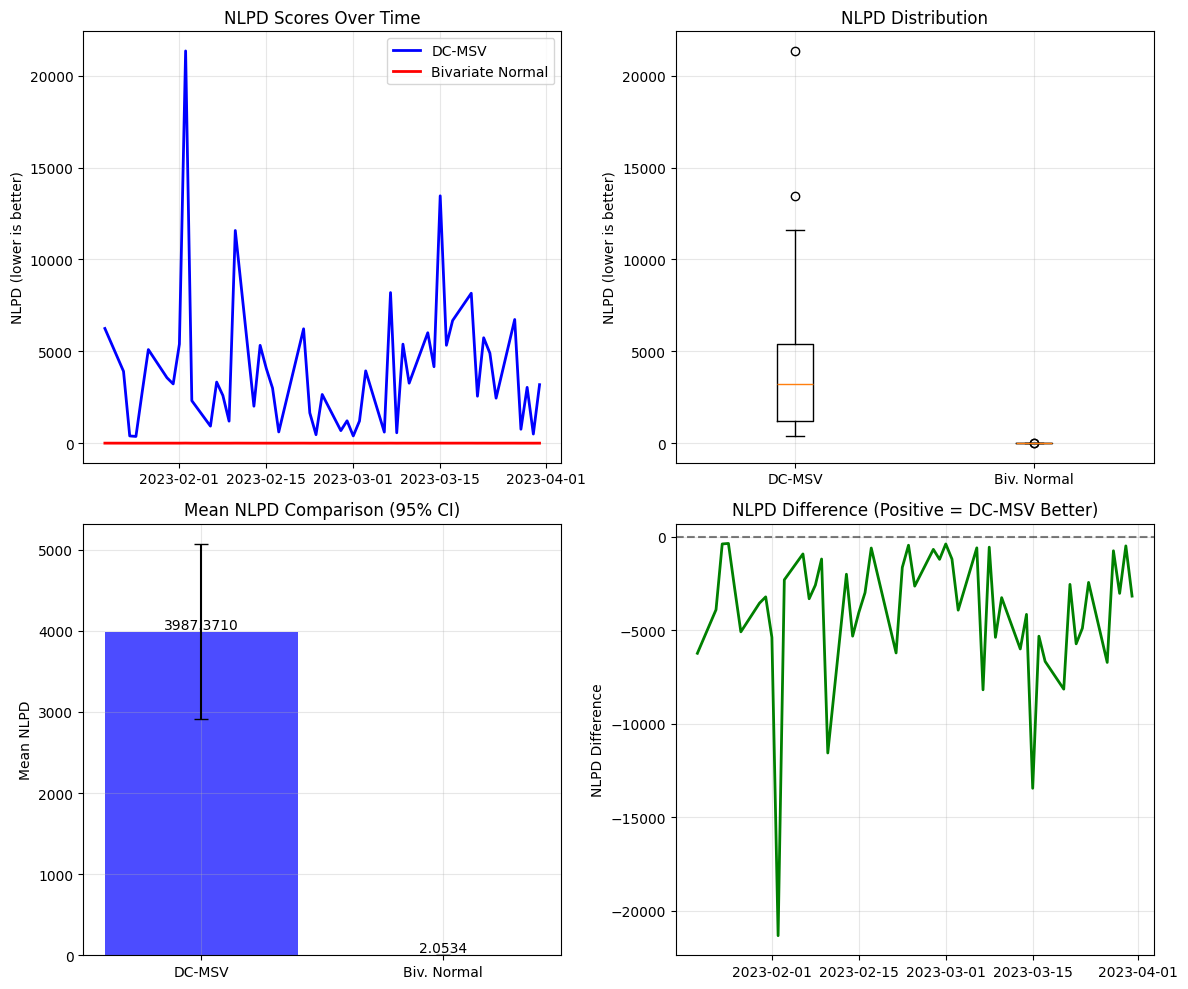


✅ NLPD analysis completed!


In [22]:
# Example usage with split_data_2d output
# Assuming returns_df, returns_array, and numpyro_estimation_dc_msv_optimized are defined
# Split data
train_df, test_df, train_array, test_array = split_data_2d(returns_df, returns_array, train_ratio=0.8)

# Calculate NLPD
print("📊 Calculating NLPD scores for 2D models...")
baseline_nlpd = calculate_nlpd_2d(test_array, 'bivariate_normal')
dc_msv_nlpd = calculate_nlpd_2d(test_array, 'dc_msv', results['estimates'], results['samples'])
nlpd_comparison_2d = compare_nlpd_scores_2d(dc_msv_nlpd, baseline_nlpd, test_df)
print(f"\n✅ NLPD analysis completed!")

## Special Visualisations

📊 Creating 2D return distribution visualizations...
1. 2D Predictive distributions at selected time points:


📊 Creating 2D return distribution visualizations...
1. 2D Predictive distributions at selected time points:


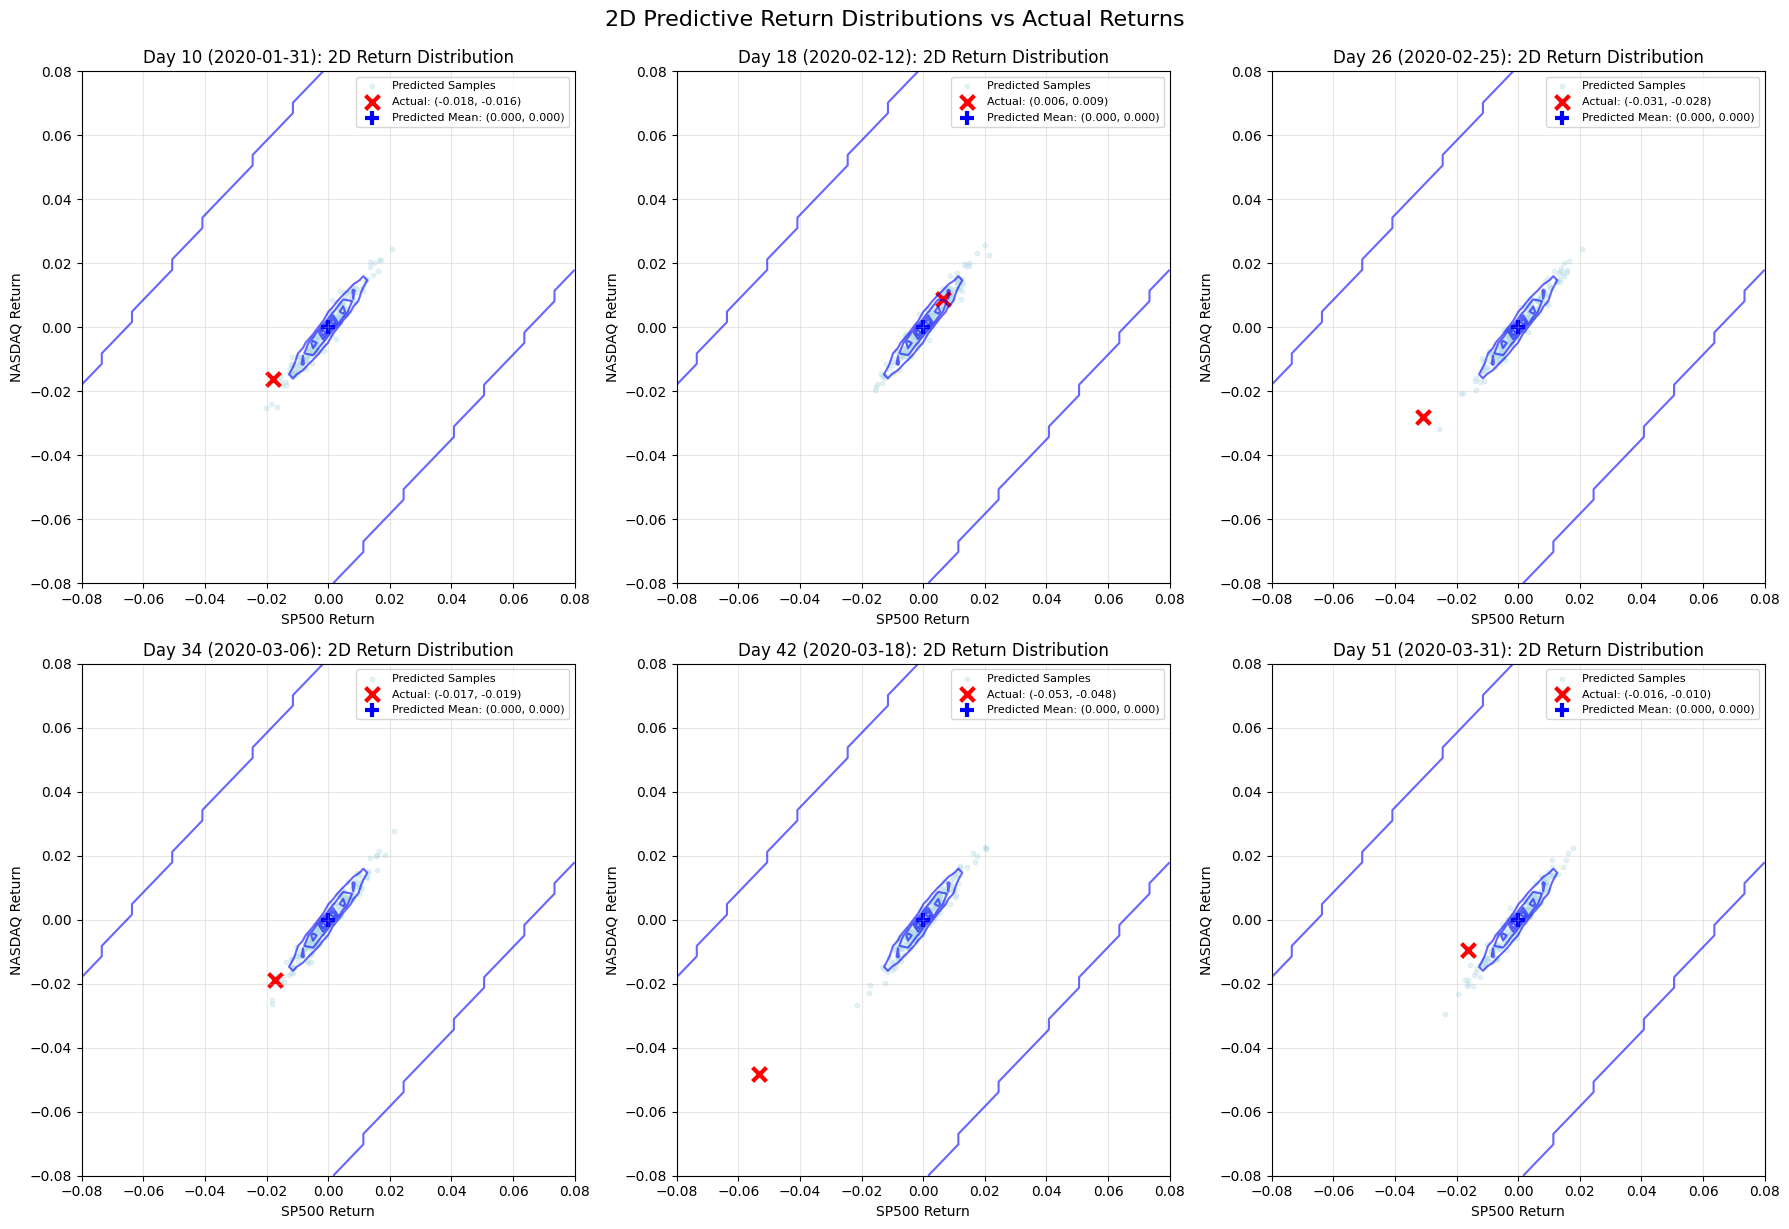

📊 Creating 2D return distribution visualizations...
1. 2D Predictive distributions at selected time points:


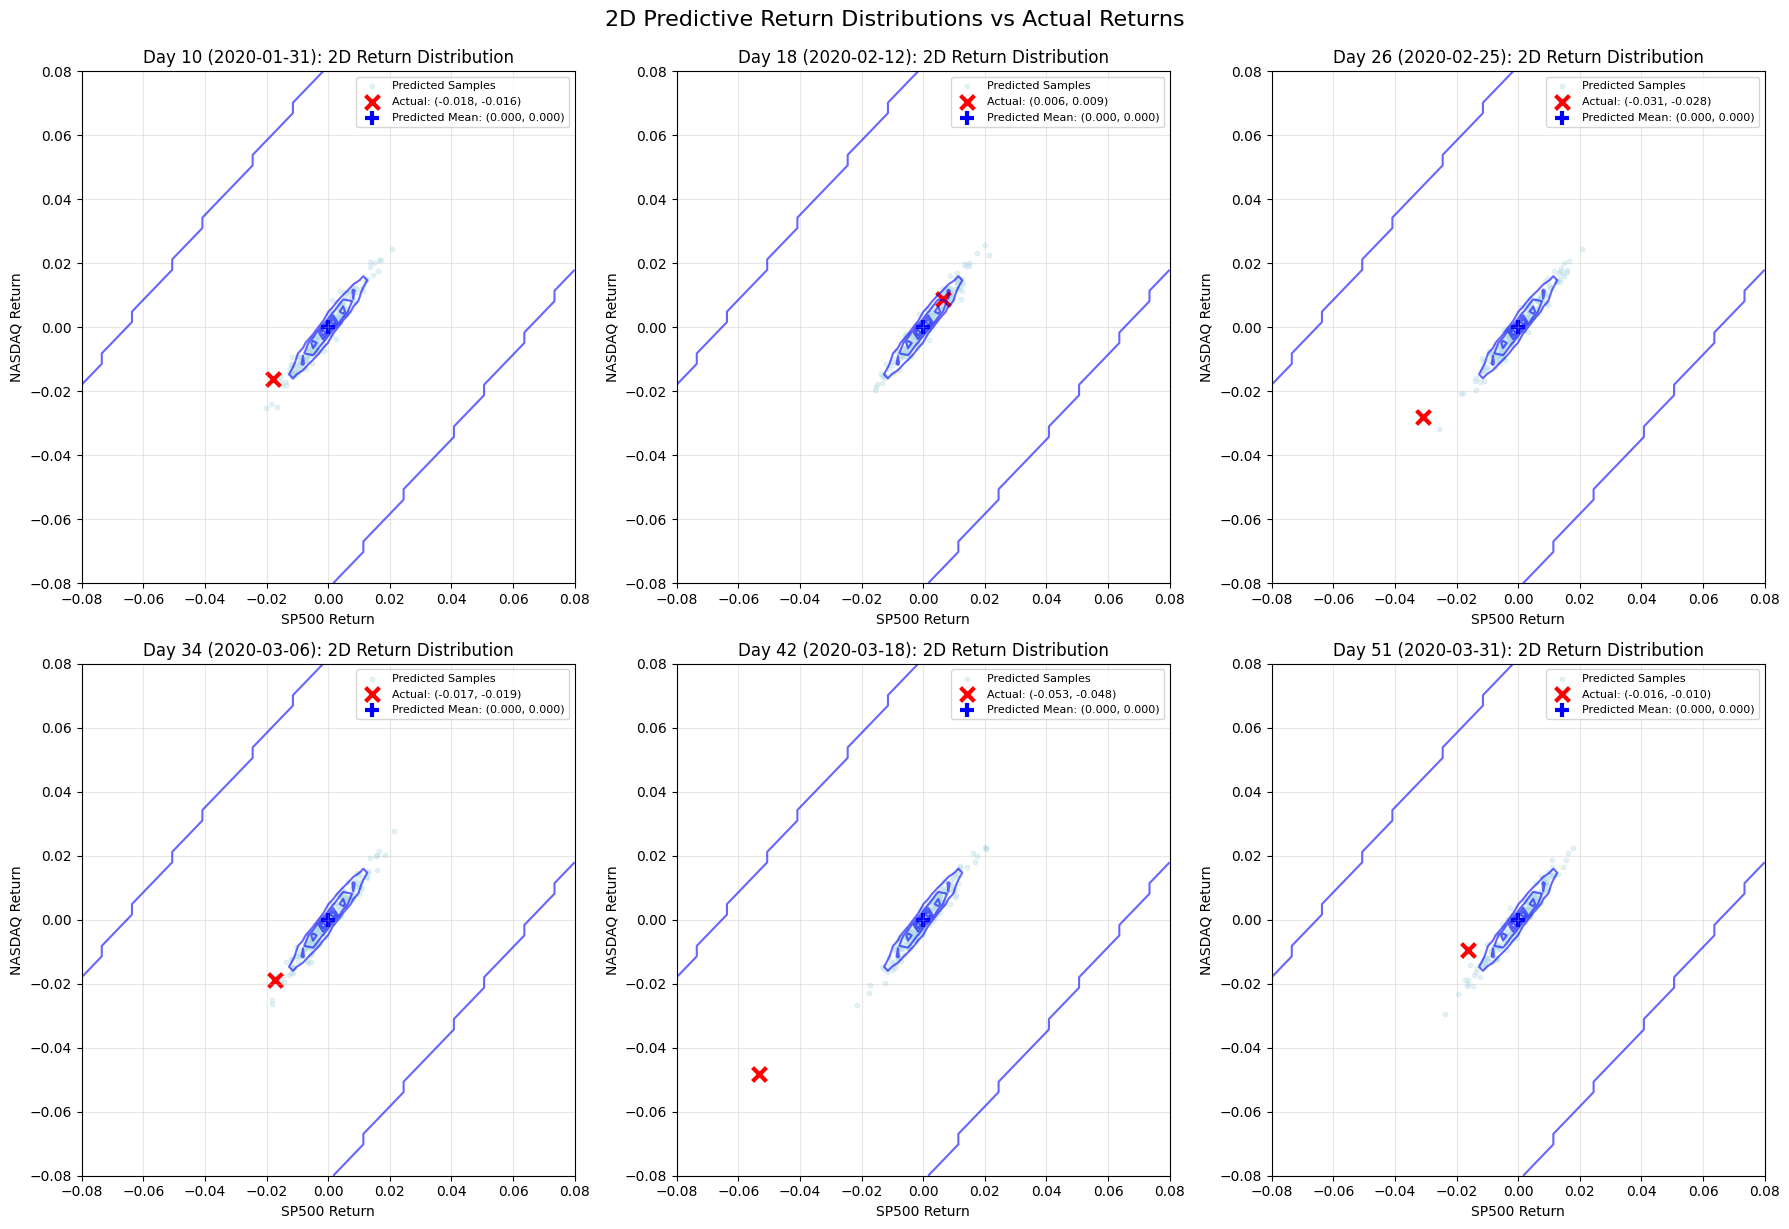

2. 2D Prediction intervals and coverage:
Falling back to constant volatilities: filtering_results not available
Using constant volatilities from DC-MSV parameters


📊 Creating 2D return distribution visualizations...
1. 2D Predictive distributions at selected time points:


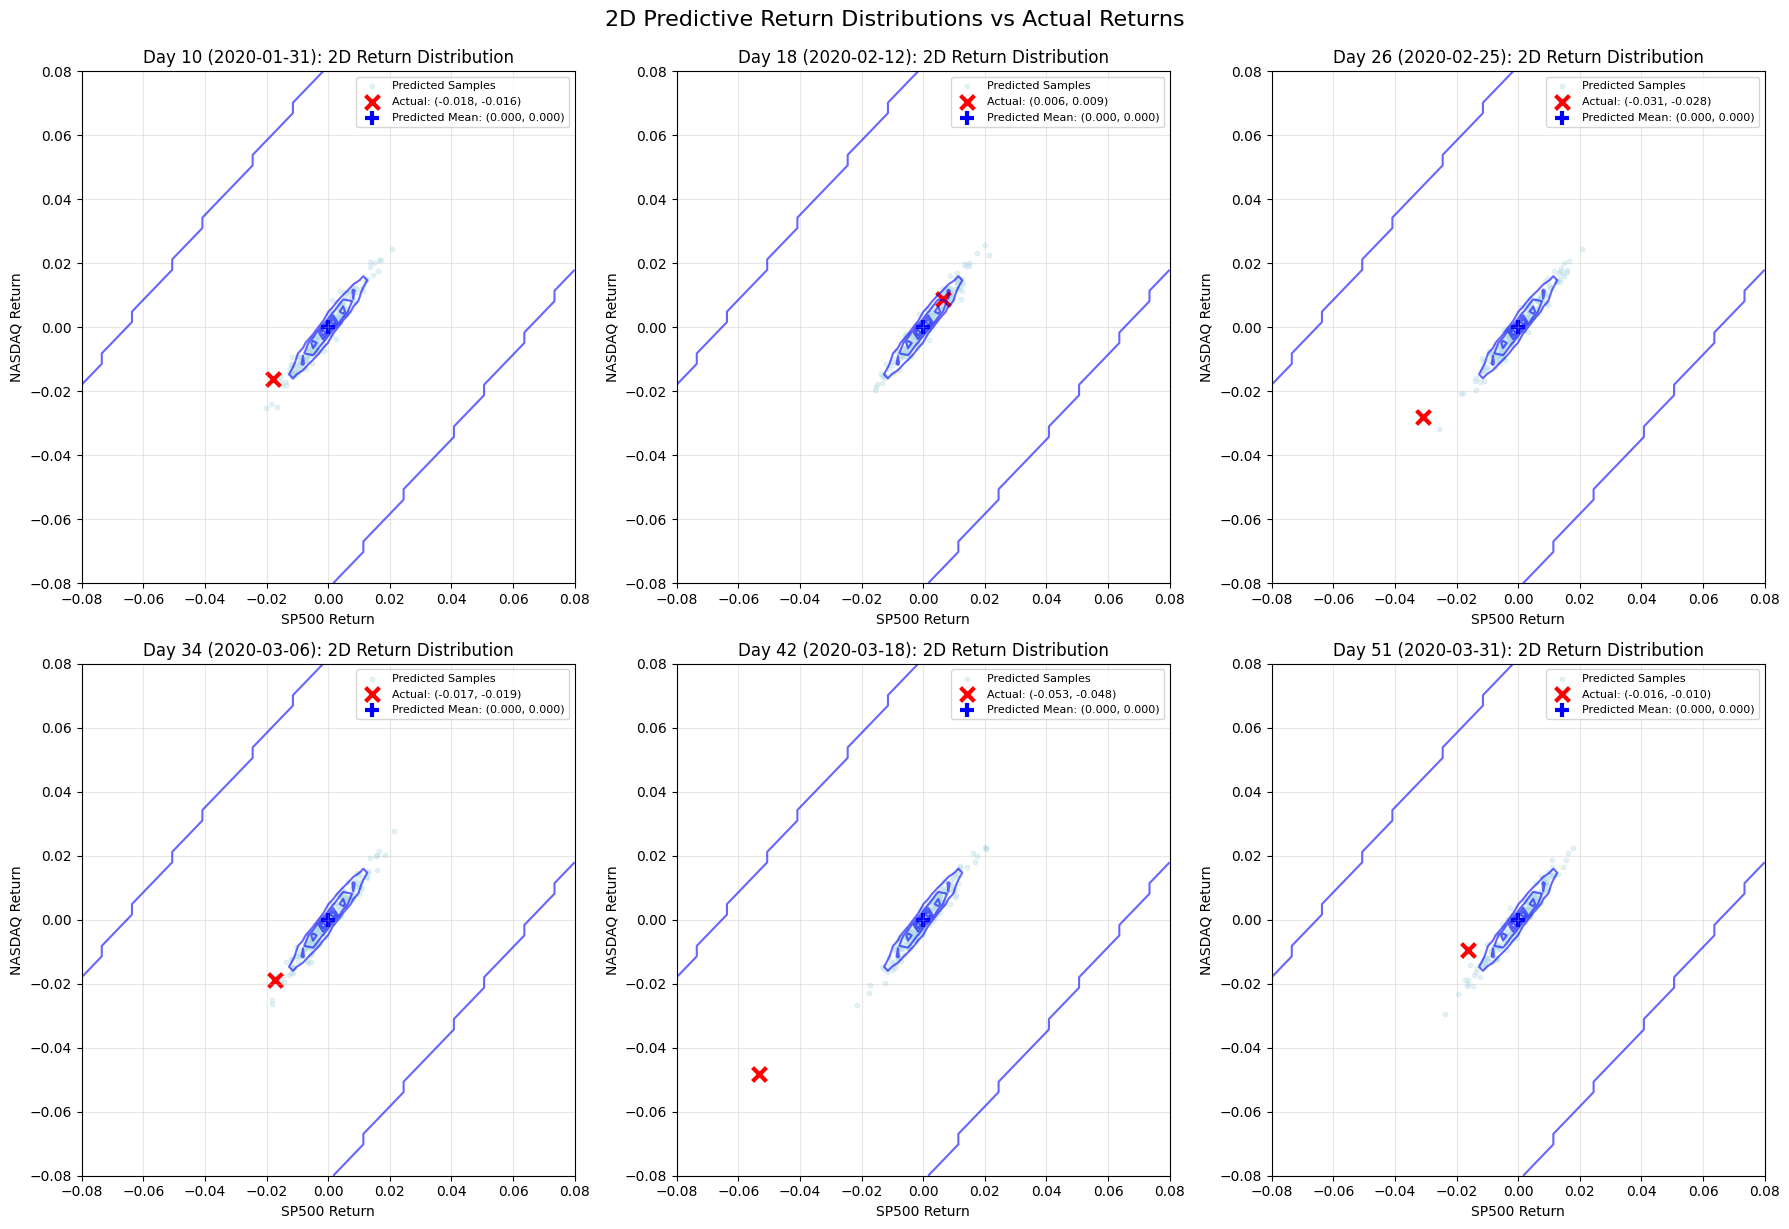

2. 2D Prediction intervals and coverage:
Falling back to constant volatilities: filtering_results not available
Using constant volatilities from DC-MSV parameters


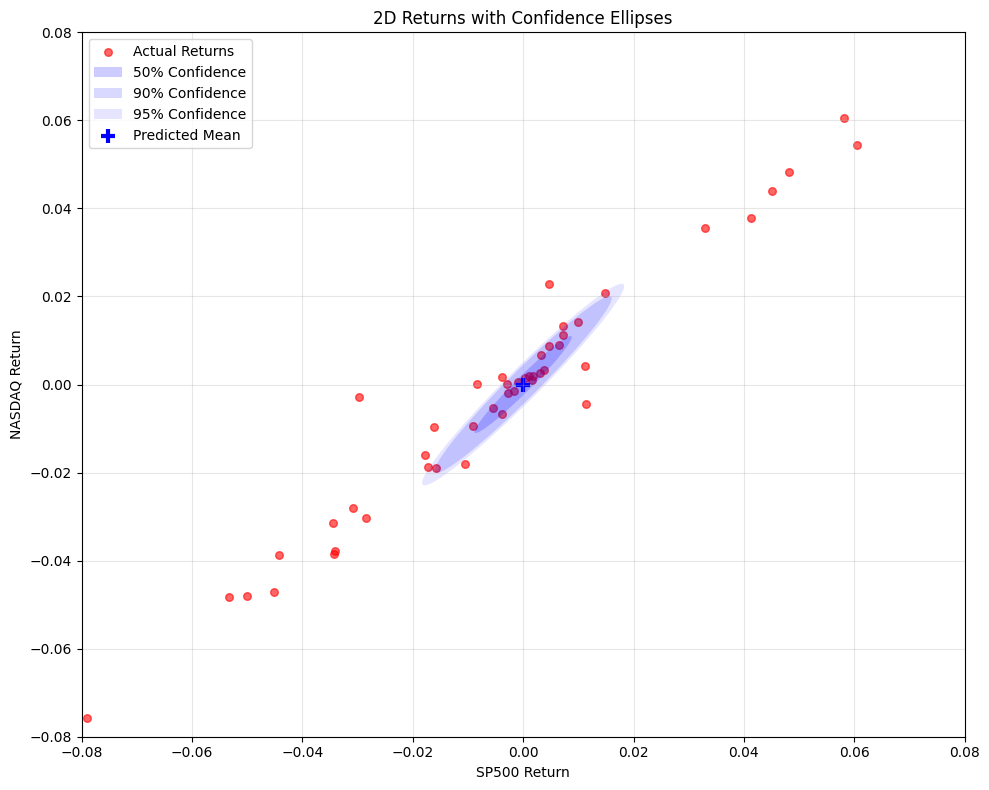

📊 Creating 2D return distribution visualizations...
1. 2D Predictive distributions at selected time points:


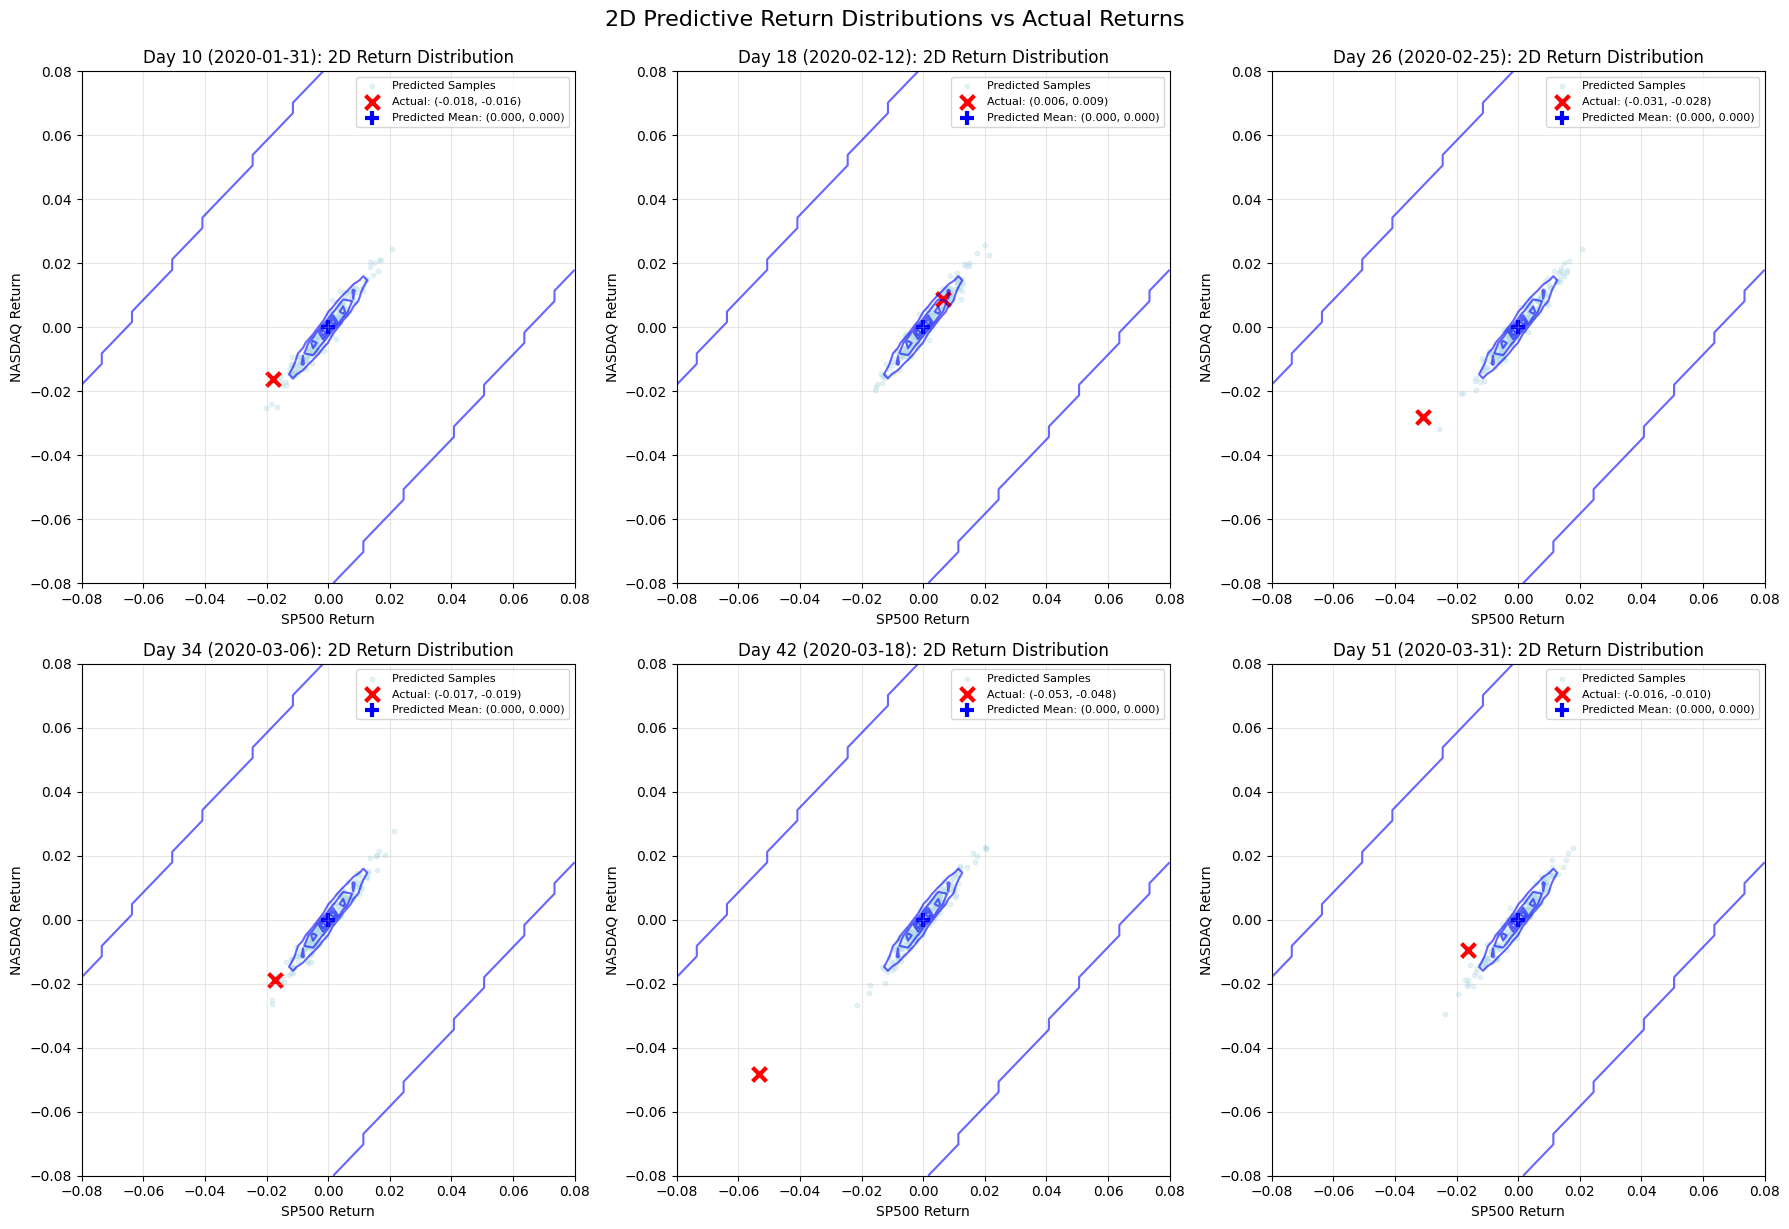

2. 2D Prediction intervals and coverage:
Falling back to constant volatilities: filtering_results not available
Using constant volatilities from DC-MSV parameters


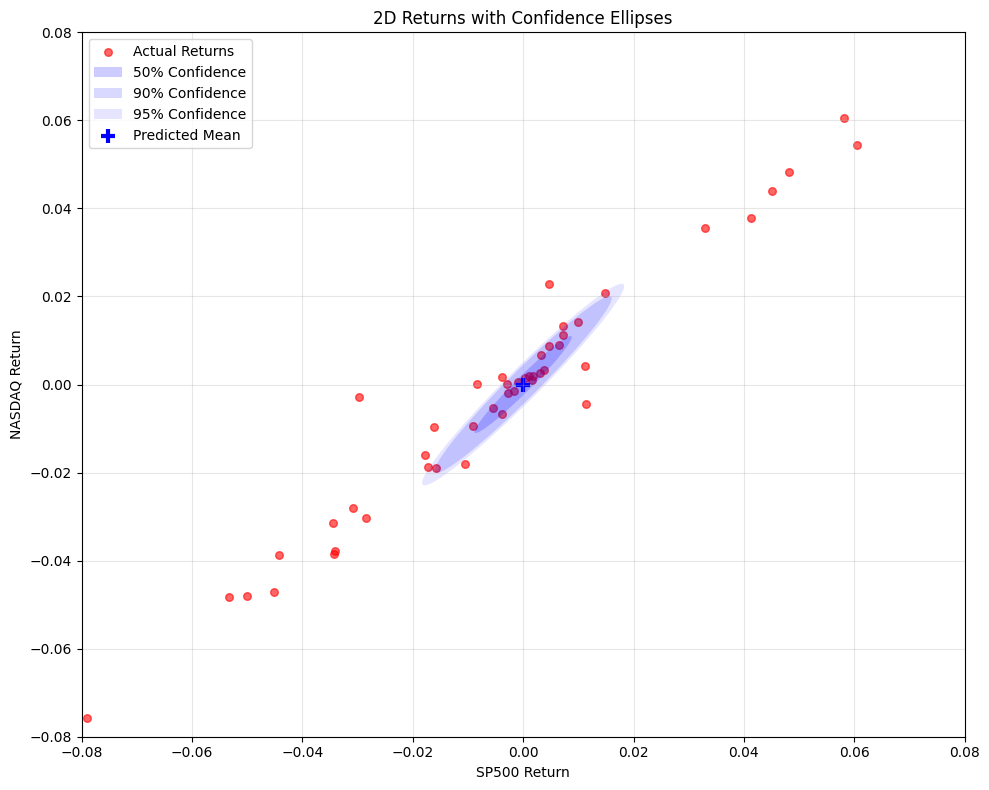

📊 2D Prediction Coverage Statistics:
Multivariate Coverage (Mahalanobis):
  50% region: 23.5% (target: 50%)
  90% region: 37.3% (target: 90%)
  95% region: 41.2% (target: 95%)
3. Correlation structure analysis:


📊 Creating 2D return distribution visualizations...
1. 2D Predictive distributions at selected time points:


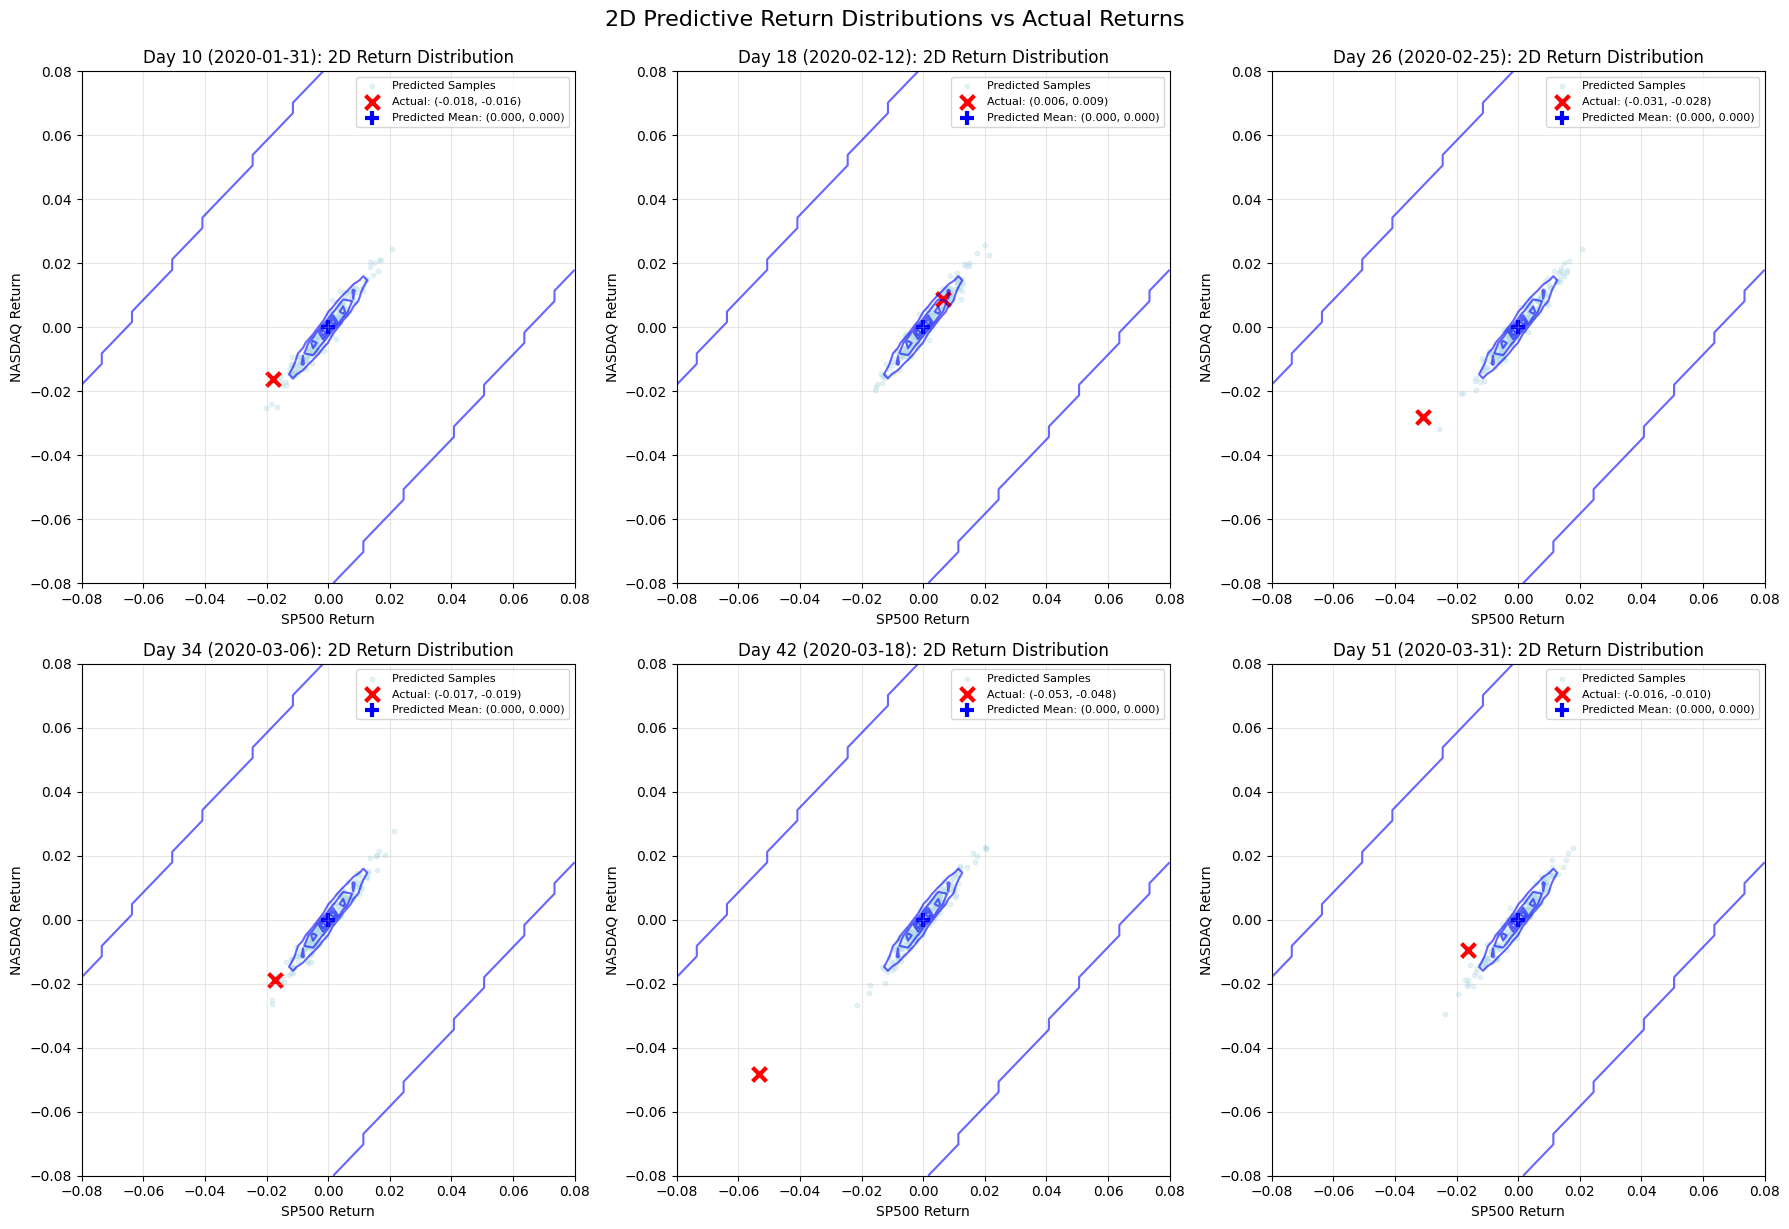

2. 2D Prediction intervals and coverage:
Falling back to constant volatilities: filtering_results not available
Using constant volatilities from DC-MSV parameters


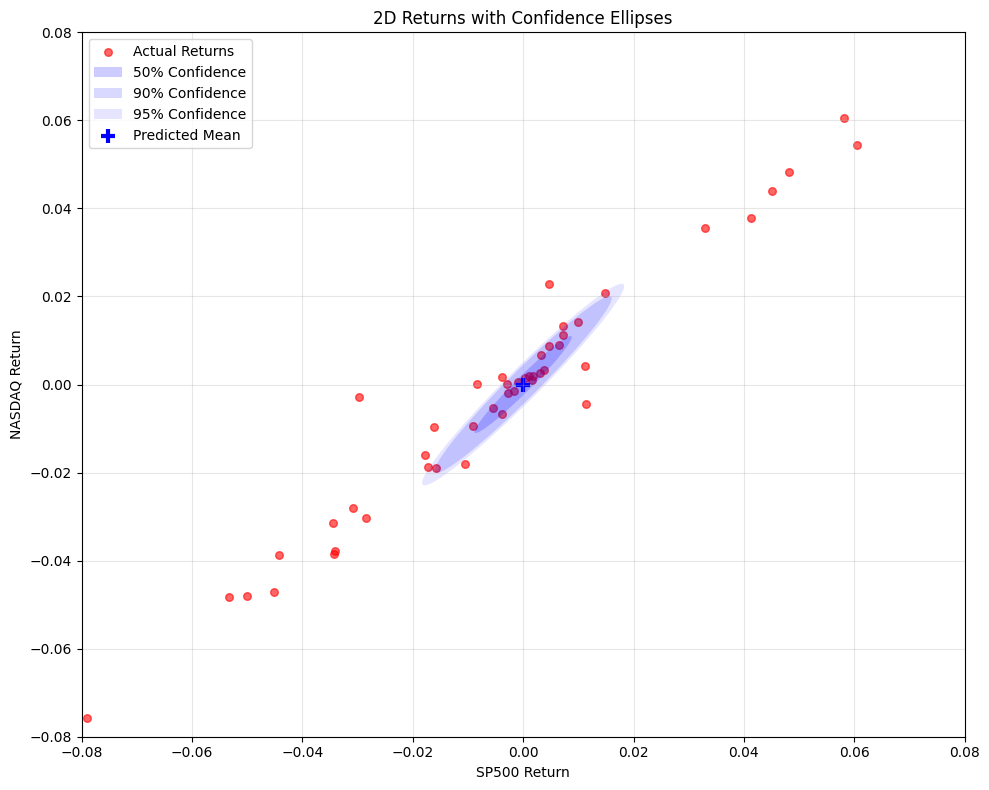

📊 2D Prediction Coverage Statistics:
Multivariate Coverage (Mahalanobis):
  50% region: 23.5% (target: 50%)
  90% region: 37.3% (target: 90%)
  95% region: 41.2% (target: 95%)
3. Correlation structure analysis:


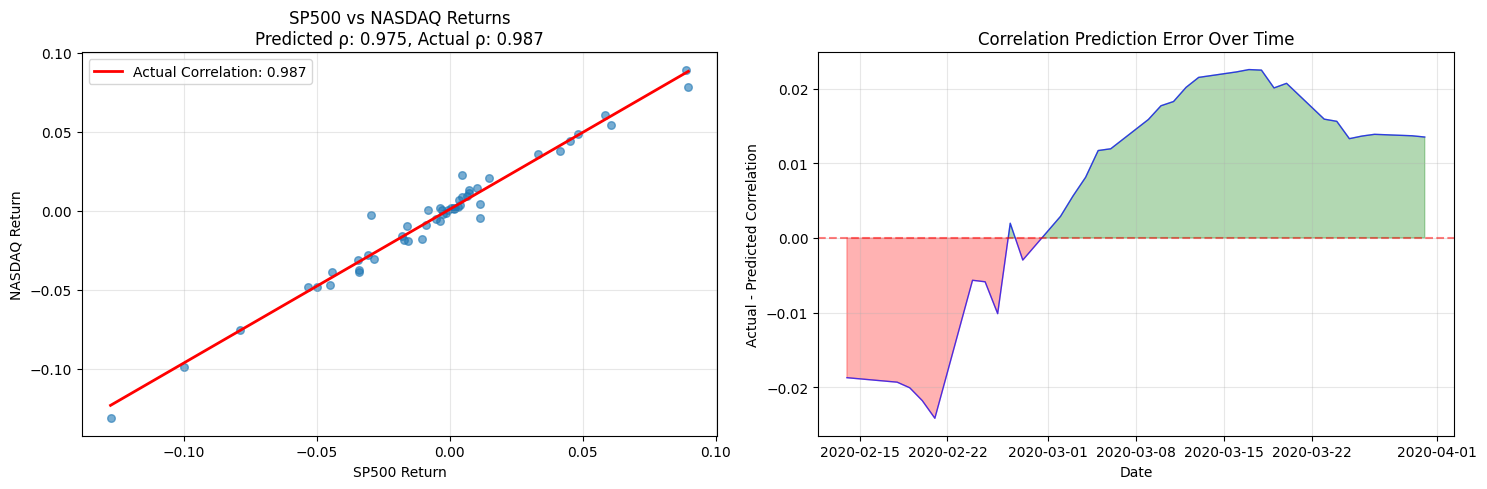

📊 Correlation Analysis Summary:
DC-MSV Predicted Correlation: 0.9750
Sample Correlation:           0.9872
Correlation Error:            0.0122
Mean 20-day Rolling Corr:     0.9817
Std 20-day Rolling Corr:      0.0149


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import gaussian_kde

def plot_2d_return_distributions(dc_msv_params, actual_returns, test_df, n_examples=6):
    """
    Plot predictive 2D return distributions vs actual returns for selected time points
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Start from day 10 and select time points evenly spaced throughout the test period
    start_point = 9  # Day 10 (0-indexed)
    max_point = len(actual_returns) - 1
    time_points = np.linspace(start_point, max_point, n_examples, dtype=int)
    
    # Extract DC-MSV parameters
    mu1, mu2 = dc_msv_params['mu1']['mean'], dc_msv_params['mu2']['mean']
    mu0 = dc_msv_params['mu0']['mean']
    sigma1, sigma2 = dc_msv_params['sigma1']['mean'], dc_msv_params['sigma2']['mean']
    
    # Average correlation and volatilities
    rho_mean = (np.exp(mu0) - 1) / (np.exp(mu0) + 1)
    vol1 = np.exp(mu1/2) * np.exp(sigma1**2/8)
    vol2 = np.exp(mu2/2) * np.exp(sigma2**2/8)
    
    # Covariance matrix
    cov = np.array([[vol1**2, rho_mean * vol1 * vol2],
                    [rho_mean * vol1 * vol2, vol2**2]])
    
    for i, t in enumerate(time_points):
        if t < len(actual_returns):
            # Generate samples from predictive distribution
            n_samples = 1000
            pred_samples = np.random.multivariate_normal([0, 0], cov, n_samples)
            
            # Plot predictive distribution as contour
            x_range = np.linspace(-0.08, 0.08, 50)
            y_range = np.linspace(-0.08, 0.08, 50)
            X, Y = np.meshgrid(x_range, y_range)
            pos = np.dstack((X, Y))
            
            # Create multivariate normal for contour plotting
            from scipy.stats import multivariate_normal
            rv = multivariate_normal([0, 0], cov)
            
            # Plot contours
            axes[i].contour(X, Y, rv.pdf(pos), colors='blue', alpha=0.6, levels=5)
            
            # Scatter plot of samples
            axes[i].scatter(pred_samples[:200, 0], pred_samples[:200, 1], 
                           alpha=0.3, s=10, color='lightblue', label='Predicted Samples')
            
            # Add actual return as red point
            actual_sp500 = actual_returns[t, 0]
            actual_nasdaq = actual_returns[t, 1]
            axes[i].scatter(actual_sp500, actual_nasdaq, color='red', s=100, 
                           marker='x', linewidth=3, label=f'Actual: ({actual_sp500:.3f}, {actual_nasdaq:.3f})')
            
            # Add predicted mean
            axes[i].scatter(0, 0, color='blue', s=100, marker='+', linewidth=3,
                           label='Predicted Mean: (0.000, 0.000)')
            
            date_str = test_df.index[t].strftime('%Y-%m-%d')
            axes[i].set_title(f'Day {t+1} ({date_str}): 2D Return Distribution')
            axes[i].set_xlabel('SP500 Return')
            axes[i].set_ylabel('NASDAQ Return')
            axes[i].legend(fontsize=8)
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlim(-0.08, 0.08)
            axes[i].set_ylim(-0.08, 0.08)
    
    plt.tight_layout()
    plt.suptitle('2D Predictive Return Distributions vs Actual Returns', y=1.02, fontsize=16)
    plt.show()

def plot_2d_quantile_analysis(dc_msv_params, actual_returns, test_df):
    """
    Analyze 2D prediction quality using time-varying volatilities from filtering results
    """
    # Try to use filtering results for time-varying volatilities if available
    try:
        if 'filtering_results' in globals() and filtering_results is not None:
            # Check if filtering_results has the expected structure
            if isinstance(filtering_results, dict) and 'filtered_states' in filtering_results:
                # Extract time-varying volatilities from filtered states
                filtered_states = filtering_results['filtered_states']
                h1_filtered = filtered_states['h1_mean']
                h2_filtered = filtered_states['h2_mean'] 
                q_filtered = filtered_states['q_mean']
                
                # Convert to actual volatilities and correlations (daily scale)
                vol1_daily = np.exp(h1_filtered / 2)  # Daily volatility
                vol2_daily = np.exp(h2_filtered / 2)  # Daily volatility
                rho_daily = (np.exp(q_filtered) - 1) / (np.exp(q_filtered) + 1)
                
                # Ensure we have the right length (match test period)
                n_periods = len(actual_returns)
                if len(vol1_daily) > n_periods:
                    vol1_daily = vol1_daily[:n_periods]
                    vol2_daily = vol2_daily[:n_periods]
                    rho_daily = rho_daily[:n_periods]
                elif len(vol1_daily) < n_periods:
                    # Extend with last values if needed
                    vol1_daily = np.pad(vol1_daily, (0, n_periods - len(vol1_daily)), 'edge')
                    vol2_daily = np.pad(vol2_daily, (0, n_periods - len(vol2_daily)), 'edge')
                    rho_daily = np.pad(rho_daily, (0, n_periods - len(rho_daily)), 'edge')
                
                print("Using time-varying volatilities from filtering results")
                use_time_varying = True
            else:
                raise KeyError("filtering_results structure not as expected")
        else:
            raise NameError("filtering_results not available")
    except (NameError, KeyError, IndexError, TypeError) as e:
        print(f"Falling back to constant volatilities: {e}")
        use_time_varying = False
        
    if not use_time_varying:
        # Fallback: use constant estimates from DC-MSV parameters
        mu1, mu2 = dc_msv_params['mu1']['mean'], dc_msv_params['mu2']['mean']
        mu0 = dc_msv_params['mu0']['mean']
        sigma1, sigma2 = dc_msv_params['sigma1']['mean'], dc_msv_params['sigma2']['mean']
        
        # Constant volatilities and correlation
        vol1_const = np.exp(mu1/2) * np.exp(sigma1**2/8)
        vol2_const = np.exp(mu2/2) * np.exp(sigma2**2/8)
        rho_const = (np.exp(mu0) - 1) / (np.exp(mu0) + 1)
        
        # Create arrays for time-varying (but actually constant) values
        n_periods = len(actual_returns)
        vol1_daily = np.full(n_periods, vol1_const)
        vol2_daily = np.full(n_periods, vol2_const)
        rho_daily = np.full(n_periods, rho_const)
        print("Using constant volatilities from DC-MSV parameters")
    
    n_periods = len(actual_returns)
    
    # Calculate time-varying prediction intervals
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    sp500_quantiles_time = np.zeros((5, n_periods))
    nasdaq_quantiles_time = np.zeros((5, n_periods))
    
    for t in range(n_periods):
        for i, q in enumerate(quantiles):
            sp500_quantiles_time[i, t] = stats.norm.ppf(q, 0, vol1_daily[t])
            nasdaq_quantiles_time[i, t] = stats.norm.ppf(q, 0, vol2_daily[t])
    
    
    # Calculate time-varying Mahalanobis distances
    from scipy.stats import chi2
    mahal_distances = []
    for t in range(n_periods):
        # Time-varying covariance matrix
        cov_t = np.array([[vol1_daily[t]**2, rho_daily[t] * vol1_daily[t] * vol2_daily[t]],
                         [rho_daily[t] * vol1_daily[t] * vol2_daily[t], vol2_daily[t]**2]])
        diff = actual_returns[t] - np.array([0, 0])
        mahal_dist = np.sqrt(diff.T @ np.linalg.inv(cov_t) @ diff)
        mahal_distances.append(mahal_dist)
    
    mahal_distances = np.array(mahal_distances)
    
    # Create time-varying prediction intervals 
    dates = test_df.index[:len(actual_returns)]
    
    # Create single plot - only 2D scatter with confidence ellipses
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # 2D scatter plot with confidence ellipses using average covariance
    from matplotlib.patches import Ellipse
    
    # Use average covariance for ellipse visualization
    avg_vol1 = np.mean(vol1_daily)
    avg_vol2 = np.mean(vol2_daily)
    avg_rho = np.mean(rho_daily)
    avg_cov = np.array([[avg_vol1**2, avg_rho * avg_vol1 * avg_vol2],
                       [avg_rho * avg_vol1 * avg_vol2, avg_vol2**2]])
    
    # Plot actual returns
    ax.scatter(actual_returns[:, 0], actual_returns[:, 1], 
               alpha=0.6, s=30, color='red', label='Actual Returns')
    
    # Add confidence ellipses
    eigenvals, eigenvecs = np.linalg.eigh(avg_cov)
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    
    # 50%, 90%, 95% confidence ellipses
    for confidence, color, alpha in [(0.5, 'blue', 0.2), (0.9, 'blue', 0.15), (0.95, 'blue', 0.1)]:
        chi2_val = chi2.ppf(confidence, df=2)
        width = 2 * np.sqrt(chi2_val * eigenvals[0])
        height = 2 * np.sqrt(chi2_val * eigenvals[1])
        
        ellipse = Ellipse(xy=(0, 0), width=width, height=height, angle=angle,
                         facecolor=color, alpha=alpha, label=f'{confidence*100:.0f}% Confidence')
        ax.add_patch(ellipse)
    
    ax.scatter(0, 0, color='blue', s=100, marker='+', linewidth=3, label='Predicted Mean')
    ax.set_title('2D Returns with Confidence Ellipses')
    ax.set_xlabel('SP500 Return')
    ax.set_ylabel('NASDAQ Return')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.08, 0.08)
    ax.set_ylim(-0.08, 0.08)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate coverage statistics using multivariate Mahalanobis distance only
    # Multivariate coverage using Mahalanobis distance
    mahal_coverage_50 = np.mean(mahal_distances**2 <= chi2.ppf(0.5, df=2))
    mahal_coverage_90 = np.mean(mahal_distances**2 <= chi2.ppf(0.9, df=2))
    mahal_coverage_95 = np.mean(mahal_distances**2 <= chi2.ppf(0.95, df=2))
    
    print(f"📊 2D Prediction Coverage Statistics:")
    print(f"=" * 50)
    print(f"Multivariate Coverage (Mahalanobis):")
    print(f"  50% region: {mahal_coverage_50:.1%} (target: 50%)")
    print(f"  90% region: {mahal_coverage_90:.1%} (target: 90%)")
    print(f"  95% region: {mahal_coverage_95:.1%} (target: 95%)")
    
    return {
        'multivariate_coverage': (mahal_coverage_50, mahal_coverage_90, mahal_coverage_95),
        'mahalanobis_distances': mahal_distances
    }

def plot_correlation_analysis(dc_msv_params, actual_returns, test_df):
    """
    Analyze the predicted vs actual correlation structure
    """
    # Extract DC-MSV correlation parameter
    mu0 = dc_msv_params['mu0']['mean']
    predicted_correlation = (np.exp(mu0) - 1) / (np.exp(mu0) + 1)
    
    # Calculate rolling correlation of actual returns
    returns_df = pd.DataFrame(actual_returns, columns=['SP500', 'NASDAQ'], index=test_df.index[:len(actual_returns)])
    
    # Different window sizes for rolling correlation
    windows = [20, 50, 100]
    
    # Only keep the second row plots - create 1 row with 2 plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Calculate sample correlation
    sample_correlation = np.corrcoef(actual_returns.T)[0, 1]
    
    # 1. Scatter plot of returns with correlation info (was axes[1, 0])
    axes[0].scatter(actual_returns[:, 0], actual_returns[:, 1], alpha=0.6, s=30)
    
    # Add regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(actual_returns[:, 0], actual_returns[:, 1])
    line_x = np.array([actual_returns[:, 0].min(), actual_returns[:, 0].max()])
    line_y = slope * line_x + intercept
    axes[0].plot(line_x, line_y, 'r-', linewidth=2, 
                   label=f'Actual Correlation: {r_value:.3f}')
    
    axes[0].set_title(f'SP500 vs NASDAQ Returns\nPredicted ρ: {predicted_correlation:.3f}, Actual ρ: {r_value:.3f}')
    axes[0].set_xlabel('SP500 Return')
    axes[0].set_ylabel('NASDAQ Return')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Correlation error over time (was axes[1, 1])
    if len(returns_df) >= 20:
        rolling_corr_20 = returns_df['SP500'].rolling(window=20).corr(returns_df['NASDAQ'])
        corr_error = rolling_corr_20 - predicted_correlation
        
        axes[1].plot(corr_error.index, corr_error.values, 'b-', linewidth=1, alpha=0.7)
        axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[1].fill_between(corr_error.index, corr_error.values, 0, 
                               where=(corr_error.values > 0), alpha=0.3, color='green', interpolate=True)
        axes[1].fill_between(corr_error.index, corr_error.values, 0, 
                               where=(corr_error.values <= 0), alpha=0.3, color='red', interpolate=True)
        axes[1].set_title('Correlation Prediction Error Over Time')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Actual - Predicted Correlation')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation analysis summary
    print(f"📊 Correlation Analysis Summary:")
    print(f"=" * 40)
    print(f"DC-MSV Predicted Correlation: {predicted_correlation:.4f}")
    print(f"Sample Correlation:           {sample_correlation:.4f}")
    print(f"Correlation Error:            {abs(sample_correlation - predicted_correlation):.4f}")
    
    if len(returns_df) >= 20:
        rolling_corr_20 = returns_df['SP500'].rolling(window=20).corr(returns_df['NASDAQ']).dropna()
        mean_rolling_corr = rolling_corr_20.mean()
        std_rolling_corr = rolling_corr_20.std()
        
        print(f"Mean 20-day Rolling Corr:     {mean_rolling_corr:.4f}")
        print(f"Std 20-day Rolling Corr:      {std_rolling_corr:.4f}")
    
    return {
        'predicted_correlation': predicted_correlation,
        'sample_correlation': sample_correlation,
        'correlation_error': abs(sample_correlation - predicted_correlation)
    }

# Run the 2D visualizations
print("📊 Creating 2D return distribution visualizations...")

# 1. 2D Distribution snapshots at different time points
print("1. 2D Predictive distributions at selected time points:")
plot_2d_return_distributions(results['estimates'], test_array_decimal, test_df)

# 2. 2D Quantile-based analysis
print("2. 2D Prediction intervals and coverage:")
coverage_stats_2d = plot_2d_quantile_analysis(results['estimates'], test_array_decimal, test_df)

# 3. Correlation analysis
print("3. Correlation structure analysis:")
correlation_stats = plot_correlation_analysis(results['estimates'], test_array_decimal, test_df)

4. Dynamic Volatility Surface Analysis:


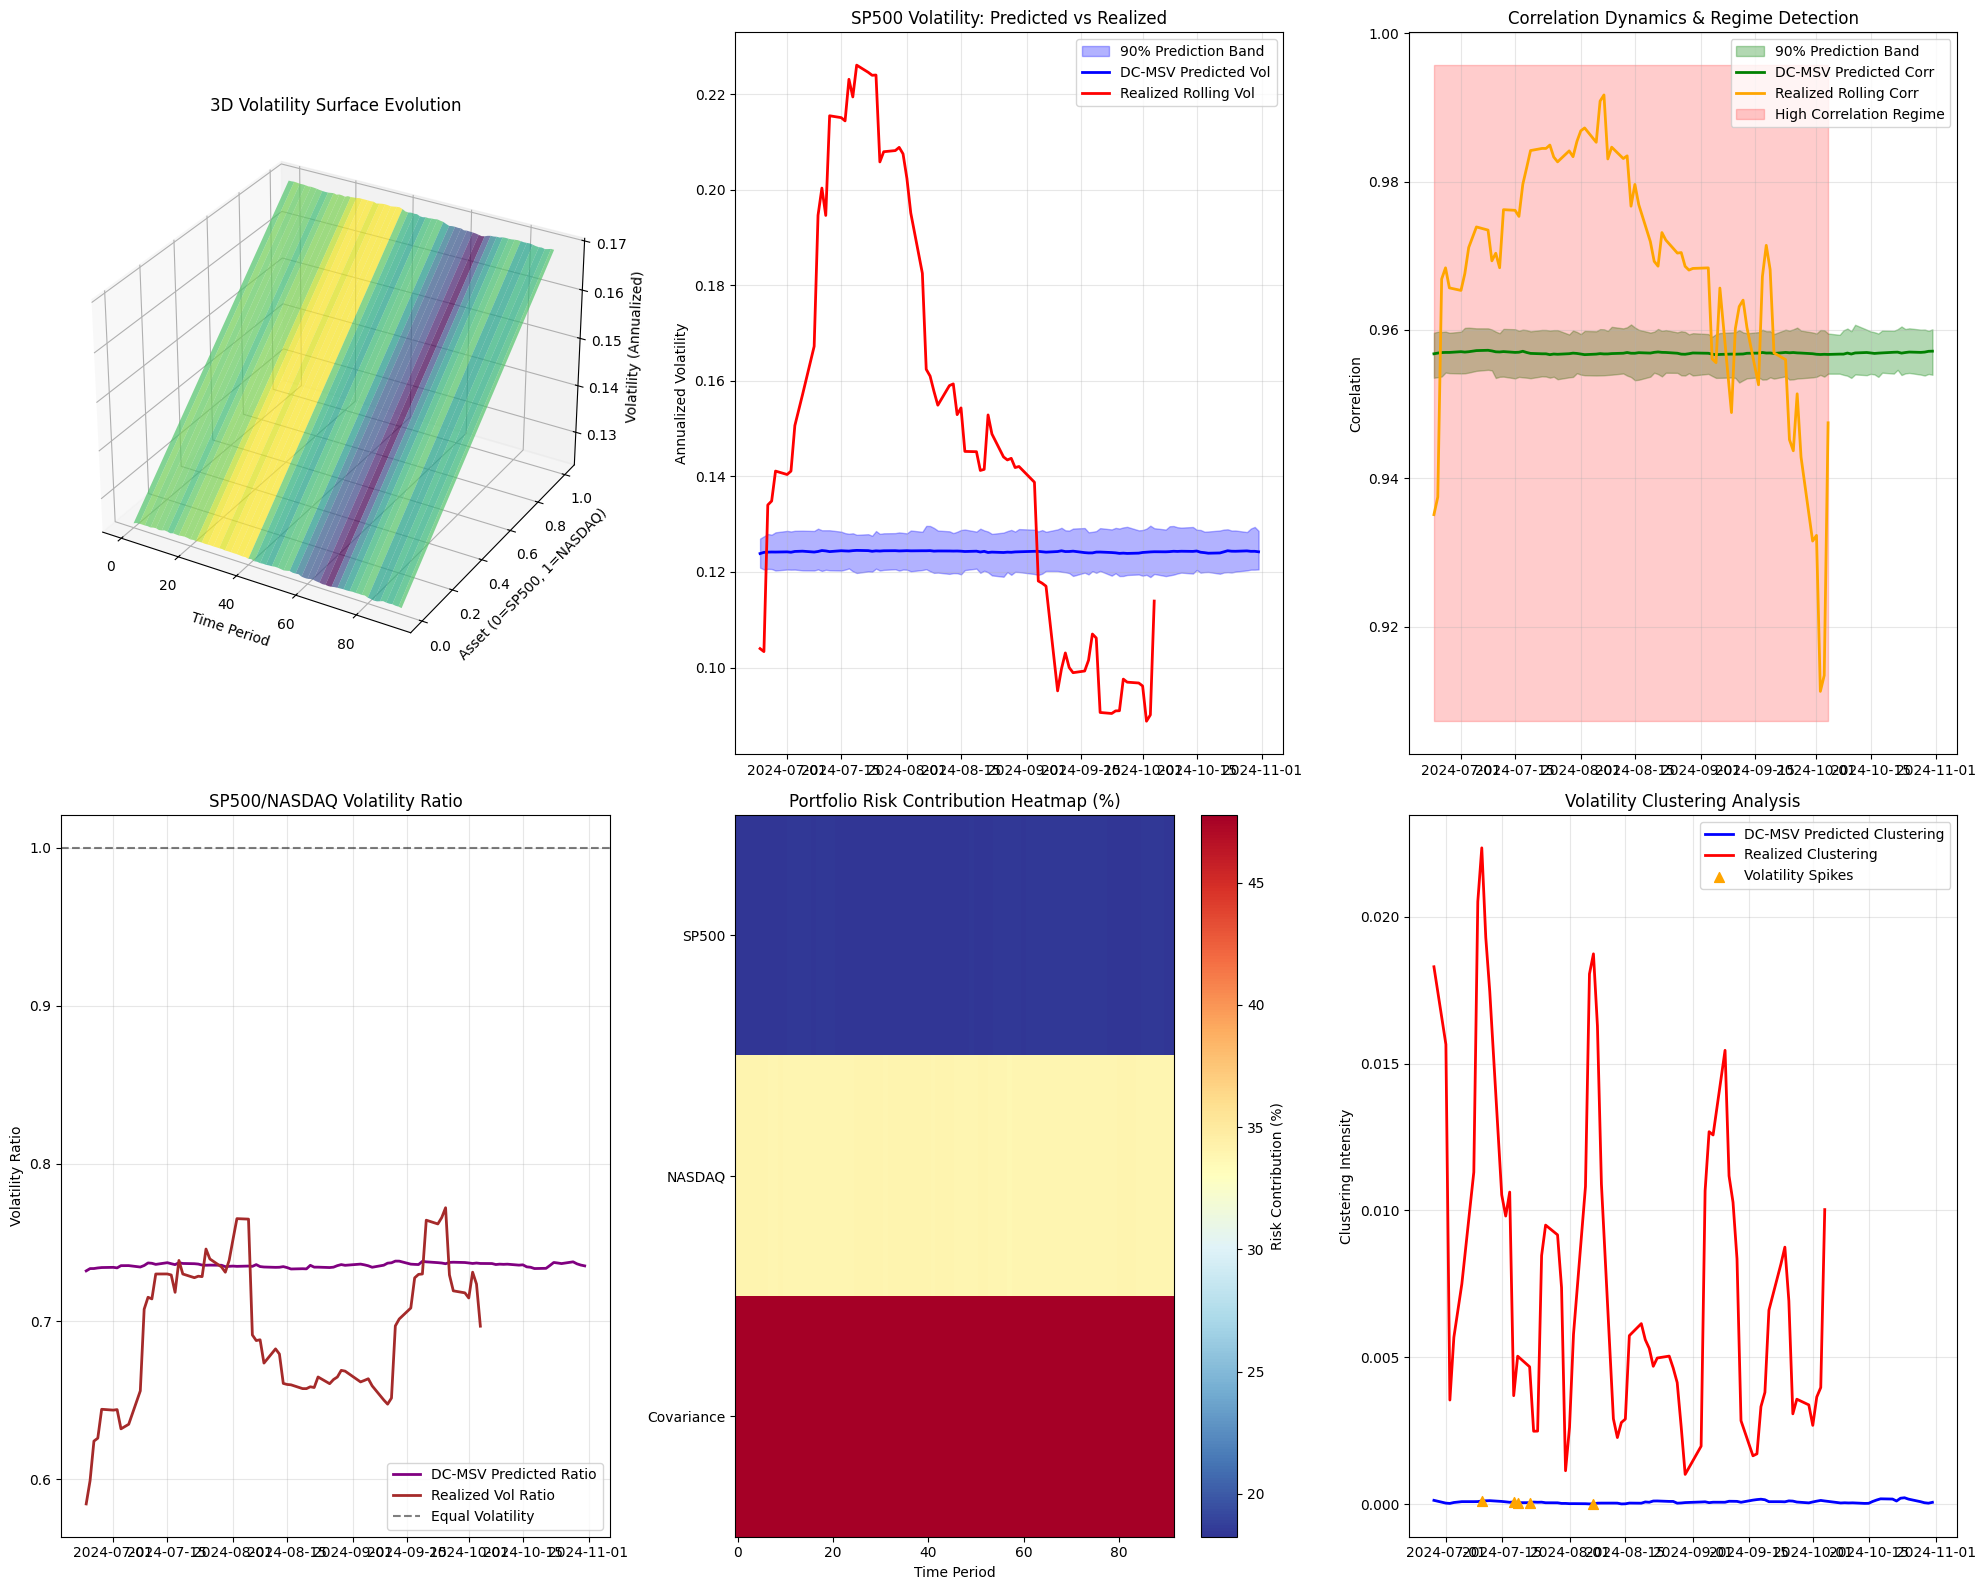

📊 Advanced Volatility Surface Analysis:
Volatility Prediction Accuracy (MAPE):
  SP500:  25.56%
  NASDAQ: 27.54%
  Correlation: 1.79%

Volatility Clustering Correlation: 0.035
Portfolio Risk Contribution Stability: 1.000

Regime Detection:
  High correlation periods: 73 days (100.0%)
  Low correlation periods:  0 days (0.0%)


In [112]:
def plot_dynamic_volatility_surface_analysis(dc_msv_params, actual_returns, test_df, train_array_decimal):
    """
    Advanced visualization of dynamic volatility surfaces and correlation evolution
    This shows the time-varying nature of the DC-MSV model vs static baselines
    """
    import matplotlib.dates as mdates
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.patches import Rectangle
    
    # Extract DC-MSV parameters
    mu1, mu2 = dc_msv_params['mu1']['mean'], dc_msv_params['mu2']['mean']
    phi11, phi22 = dc_msv_params['phi11']['mean'], dc_msv_params['phi22']['mean']
    sigma1, sigma2 = dc_msv_params['sigma1']['mean'], dc_msv_params['sigma2']['mean']
    mu0 = dc_msv_params['mu0']['mean']
    phi = dc_msv_params['phi']['mean']
    sigma_rho = dc_msv_params['sigma_rho']['mean']
    
    # Simulate the latent volatility processes for visualization
    def simulate_volatility_paths(n_periods=len(actual_returns), n_sims=100):
        """Simulate multiple paths of the latent volatility states"""
        h1_paths = np.zeros((n_sims, n_periods))
        h2_paths = np.zeros((n_sims, n_periods))
        q_paths = np.zeros((n_sims, n_periods))
        
        # Initialize at steady state
        h1_paths[:, 0] = np.random.normal(mu1, sigma1/np.sqrt(1-phi11**2), n_sims)
        h2_paths[:, 0] = np.random.normal(mu2, sigma2/np.sqrt(1-phi22**2), n_sims)
        q_paths[:, 0] = np.random.normal(mu0, sigma_rho/np.sqrt(1-phi**2), n_sims)
        
        for t in range(1, n_periods):
            h1_paths[:, t] = mu1 + phi11 * (h1_paths[:, t-1] - mu1) + np.random.normal(0, sigma1, n_sims)
            h2_paths[:, t] = mu2 + phi22 * (h2_paths[:, t-1] - mu2) + np.random.normal(0, sigma2, n_sims)
            q_paths[:, t] = mu0 + phi * (q_paths[:, t-1] - mu0) + np.random.normal(0, sigma_rho, n_sims)
        
        return h1_paths, h2_paths, q_paths
    
    h1_sims, h2_sims, q_sims = simulate_volatility_paths()
    
    # Convert to volatilities and correlations
    vol1_sims = np.exp(h1_sims / 2)
    vol2_sims = np.exp(h2_sims / 2)
    rho_sims = (np.exp(q_sims) - 1) / (np.exp(q_sims) + 1)
    
    # Get empirical rolling volatilities for comparison
    returns_df = pd.DataFrame(actual_returns, columns=['SP500', 'NASDAQ'], 
                             index=test_df.index[:len(actual_returns)])
    
    # Calculate rolling volatilities (annualized)
    window = 20
    rolling_vol1 = returns_df['SP500'].rolling(window=window).std() * np.sqrt(252)
    rolling_vol2 = returns_df['NASDAQ'].rolling(window=window).std() * np.sqrt(252)
    rolling_corr = returns_df['SP500'].rolling(window=window).corr(returns_df['NASDAQ'])
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    
    # 1. 3D Volatility Surface (top-left)
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    dates_numeric = np.arange(len(actual_returns))  # Use numerical indices instead
    
    # Plot mean volatility surfaces
    vol1_mean = np.mean(vol1_sims, axis=0) * np.sqrt(252)  # Annualized
    vol2_mean = np.mean(vol2_sims, axis=0) * np.sqrt(252)
    
    # Create proper meshgrid for 3D surface
    X, Y = np.meshgrid(dates_numeric[:len(vol1_mean)], [0, 1])  # Use numerical asset indices
    Z = np.vstack([vol1_mean, vol2_mean])
    
    surf = ax1.plot_surface(X, Y, Z, alpha=0.7, cmap='viridis')
    ax1.set_xlabel('Time Period')
    ax1.set_ylabel('Asset (0=SP500, 1=NASDAQ)')
    ax1.set_zlabel('Volatility (Annualized)')
    ax1.set_title('3D Volatility Surface Evolution')
    
    # 2. Volatility Bands with Uncertainty (top-middle)
    ax2 = fig.add_subplot(2, 3, 2)
    dates = test_df.index[:len(actual_returns)]
    
    # Plot prediction bands
    vol1_q05 = np.percentile(vol1_sims * np.sqrt(252), 5, axis=0)
    vol1_q95 = np.percentile(vol1_sims * np.sqrt(252), 95, axis=0)
    vol1_mean_ann = vol1_mean
    
    ax2.fill_between(dates, vol1_q05, vol1_q95, alpha=0.3, color='blue', label='90% Prediction Band')
    ax2.plot(dates, vol1_mean_ann, 'b-', linewidth=2, label='DC-MSV Predicted Vol')
    
    # Handle potential NaN values in rolling volatility
    rolling_vol1_clean = rolling_vol1.dropna()
    dates_clean = dates[:len(rolling_vol1_clean)]
    ax2.plot(dates_clean, rolling_vol1_clean, 'r-', linewidth=2, label='Realized Rolling Vol')
    
    ax2.set_title('SP500 Volatility: Predicted vs Realized')
    ax2.set_ylabel('Annualized Volatility')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Correlation Dynamics with Regime Detection (top-right)
    ax3 = fig.add_subplot(2, 3, 3)
    
    rho_mean = np.mean(rho_sims, axis=0)
    rho_q05 = np.percentile(rho_sims, 5, axis=0)
    rho_q95 = np.percentile(rho_sims, 95, axis=0)
    
    ax3.fill_between(dates, rho_q05, rho_q95, alpha=0.3, color='green', label='90% Prediction Band')
    ax3.plot(dates, rho_mean, 'g-', linewidth=2, label='DC-MSV Predicted Corr')
    
    # Handle potential NaN values in rolling correlation
    rolling_corr_clean = rolling_corr.dropna()
    dates_corr_clean = dates[:len(rolling_corr_clean)]
    ax3.plot(dates_corr_clean, rolling_corr_clean, 'orange', linewidth=2, label='Realized Rolling Corr')
    
    # Add regime detection based on correlation levels
    high_corr_threshold = 0.8
    low_corr_threshold = 0.4
    
    high_corr_periods = rolling_corr_clean > high_corr_threshold
    low_corr_periods = rolling_corr_clean < low_corr_threshold
    
    if high_corr_periods.any():
        ax3.fill_between(dates_corr_clean, ax3.get_ylim()[0], ax3.get_ylim()[1], 
                        where=high_corr_periods, alpha=0.2, color='red', 
                        label='High Correlation Regime')
    
    ax3.set_title('Correlation Dynamics & Regime Detection')
    ax3.set_ylabel('Correlation')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Volatility Ratio Analysis (bottom-left)
    ax4 = fig.add_subplot(2, 3, 4)
    
    vol_ratio_predicted = vol1_mean / vol2_mean
    
    # Calculate realized ratio with proper handling of NaN values
    rolling_vol1_ratio = rolling_vol1.dropna()
    rolling_vol2_ratio = rolling_vol2.dropna()
    min_len = min(len(rolling_vol1_ratio), len(rolling_vol2_ratio))
    
    if min_len > 0:
        vol_ratio_realized = rolling_vol1_ratio.iloc[:min_len] / rolling_vol2_ratio.iloc[:min_len]
        dates_ratio = dates[:min_len]
        
        ax4.plot(dates[:len(vol_ratio_predicted)], vol_ratio_predicted, 'purple', linewidth=2, label='DC-MSV Predicted Ratio')
        ax4.plot(dates_ratio, vol_ratio_realized, 'brown', linewidth=2, label='Realized Vol Ratio')
    else:
        ax4.plot(dates[:len(vol_ratio_predicted)], vol_ratio_predicted, 'purple', linewidth=2, label='DC-MSV Predicted Ratio')
    
    ax4.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Equal Volatility')
    
    ax4.set_title('SP500/NASDAQ Volatility Ratio')
    ax4.set_ylabel('Volatility Ratio')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Risk Contribution Heatmap (bottom-middle)
    ax5 = fig.add_subplot(2, 3, 5)
    
    # Calculate portfolio risk contributions over time
    # Assume equal weights portfolio
    w1, w2 = 0.5, 0.5
    portfolio_var_components = np.zeros((len(actual_returns), 3))  # [SP500, NASDAQ, Covariance]
    
    for t in range(len(actual_returns)):
        vol1_t = vol1_mean[t]
        vol2_t = vol2_mean[t] 
        rho_t = rho_mean[t]
        
        portfolio_var_components[t, 0] = (w1 * vol1_t)**2  # SP500 contribution
        portfolio_var_components[t, 1] = (w2 * vol2_t)**2  # NASDAQ contribution
        portfolio_var_components[t, 2] = 2 * w1 * w2 * vol1_t * vol2_t * rho_t  # Covariance contribution
    
    # Normalize to percentages
    portfolio_var_total = np.sum(portfolio_var_components, axis=1, keepdims=True)
    portfolio_var_pct = portfolio_var_components / portfolio_var_total * 100
    
    # Create heatmap
    im = ax5.imshow(portfolio_var_pct.T, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
    ax5.set_yticks([0, 1, 2])
    ax5.set_yticklabels(['SP500', 'NASDAQ', 'Covariance'])
    ax5.set_xlabel('Time Period')
    ax5.set_title('Portfolio Risk Contribution Heatmap (%)')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax5)
    cbar.set_label('Risk Contribution (%)')
    
    # 6. Volatility Clustering Analysis (bottom-right)
    ax6 = fig.add_subplot(2, 3, 6)
    
    # Calculate volatility clustering metrics
    def volatility_clustering_metric(vol_series, window=5):
        """Calculate local volatility clustering using rolling std of volatilities"""
        return vol_series.rolling(window=window).std()
    
    vol1_clustering = volatility_clustering_metric(pd.Series(vol1_mean))
    
    # Handle NaN values in realized volatility clustering
    rolling_vol1_for_clustering = rolling_vol1.dropna()
    if len(rolling_vol1_for_clustering) > 0:
        realized_vol1_clustering = volatility_clustering_metric(rolling_vol1_for_clustering)
        dates_clustering = dates[:len(realized_vol1_clustering)]
        
        ax6.plot(dates[:len(vol1_clustering)], vol1_clustering, 'blue', linewidth=2, label='DC-MSV Predicted Clustering')
        ax6.plot(dates_clustering, realized_vol1_clustering, 'red', linewidth=2, label='Realized Clustering')
    else:
        ax6.plot(dates[:len(vol1_clustering)], vol1_clustering, 'blue', linewidth=2, label='DC-MSV Predicted Clustering')
    
    # Add volatility spike detection
    vol_spike_threshold = np.percentile(vol1_mean, 95)
    vol_spikes = vol1_mean > vol_spike_threshold
    
    if vol_spikes.any():
        spike_dates = dates[vol_spikes]
        ax6.scatter(spike_dates, vol1_clustering[vol_spikes], 
                   color='orange', s=50, marker='^', label='Volatility Spikes', zorder=5)
    
    ax6.set_title('Volatility Clustering Analysis')
    ax6.set_ylabel('Clustering Intensity')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print advanced metrics
    print(f"📊 Advanced Volatility Surface Analysis:")
    print(f"=" * 50)
    
    # Volatility prediction accuracy - handle NaN values properly
    rolling_vol1_clean = rolling_vol1.dropna()
    rolling_vol2_clean = rolling_vol2.dropna()
    
    if len(rolling_vol1_clean) > 0 and len(rolling_vol2_clean) > 0:
        min_len_vol = min(len(vol1_mean), len(rolling_vol1_clean))
        vol1_mape = np.mean(np.abs((vol1_mean[:min_len_vol] - rolling_vol1_clean.iloc[:min_len_vol]) / rolling_vol1_clean.iloc[:min_len_vol])) * 100
        
        min_len_vol2 = min(len(vol2_mean), len(rolling_vol2_clean))
        vol2_mape = np.mean(np.abs((vol2_mean[:min_len_vol2] - rolling_vol2_clean.iloc[:min_len_vol2]) / rolling_vol2_clean.iloc[:min_len_vol2])) * 100
    else:
        vol1_mape = vol2_mape = np.nan
    
    print(f"Volatility Prediction Accuracy (MAPE):")
    print(f"  SP500:  {vol1_mape:.2f}%" if not np.isnan(vol1_mape) else "  SP500:  N/A (insufficient data)")
    print(f"  NASDAQ: {vol2_mape:.2f}%" if not np.isnan(vol2_mape) else "  NASDAQ: N/A (insufficient data)")
    
    # Correlation prediction accuracy
    rolling_corr_clean = rolling_corr.dropna()
    if len(rolling_corr_clean) > 0:
        min_len_corr = min(len(rho_mean), len(rolling_corr_clean))
        corr_mape = np.mean(np.abs((rho_mean[:min_len_corr] - rolling_corr_clean.iloc[:min_len_corr]) / rolling_corr_clean.iloc[:min_len_corr])) * 100
        print(f"  Correlation: {corr_mape:.2f}%")
    else:
        corr_mape = np.nan
        print(f"  Correlation: N/A (insufficient data)")
    
    # Volatility clustering comparison
    if len(rolling_vol1_for_clustering) > 0 and len(vol1_clustering.dropna()) > 0:
        vol1_clust_clean = vol1_clustering.dropna()
        realized_vol1_clust_clean = realized_vol1_clustering.dropna()
        min_len_clust = min(len(vol1_clust_clean), len(realized_vol1_clust_clean))
        
        if min_len_clust > 1:
            clustering_correlation = np.corrcoef(vol1_clust_clean.iloc[:min_len_clust], 
                                               realized_vol1_clust_clean.iloc[:min_len_clust])[0,1]
            print(f"\nVolatility Clustering Correlation: {clustering_correlation:.3f}")
        else:
            clustering_correlation = np.nan
            print(f"\nVolatility Clustering Correlation: N/A (insufficient data)")
    else:
        clustering_correlation = np.nan
        print(f"\nVolatility Clustering Correlation: N/A (insufficient data)")
    
    # Risk contribution stability
    risk_contrib_stability = 1 - np.std(portfolio_var_pct, axis=0).mean() / 100
    print(f"Portfolio Risk Contribution Stability: {risk_contrib_stability:.3f}")
    
    # Regime detection summary
    if len(rolling_corr_clean) > 0:
        n_high_corr = high_corr_periods.sum() if high_corr_periods.any() else 0
        n_low_corr = low_corr_periods.sum() if low_corr_periods.any() else 0
        print(f"\nRegime Detection:")
        print(f"  High correlation periods: {n_high_corr} days ({n_high_corr/len(rolling_corr_clean)*100:.1f}%)")
        print(f"  Low correlation periods:  {n_low_corr} days ({n_low_corr/len(rolling_corr_clean)*100:.1f}%)")
    else:
        n_high_corr = n_low_corr = 0
        print(f"\nRegime Detection: N/A (insufficient data)")
    
    return {
        'volatility_accuracy': {'sp500_mape': vol1_mape, 'nasdaq_mape': vol2_mape},
        'correlation_accuracy': corr_mape,
        'clustering_correlation': clustering_correlation,
        'risk_contribution_stability': risk_contrib_stability,
        'regime_stats': {'high_corr_days': n_high_corr, 'low_corr_days': n_low_corr}
    }

# Run the advanced 4th visualization
print("4. Dynamic Volatility Surface Analysis:")
volatility_analysis = plot_dynamic_volatility_surface_analysis(
    results['estimates'], test_array_decimal, test_df, train_array_decimal
)